In [1]:
import os
import time
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

from multiprocessing.dummy import Pool as ThreadPool
# Turn interactive plotting off
plt.ioff()

from models import *

DEBUG = True                   # Output each main function runtime
SAVE_DATA = True                # Flag to save data below (dataframe + plots)
# PATH = r'C:\Users\Владислав\Downloads\Transport-networks-main'ё  # Base path (existing) where subfolder with results will be created
# PATH = r'C:\Users\va\Documents\Transport-networks'

PATH = '/home/sergey/projects/gasnich/Transport-networks'

# 1 person = 100 people
init_transmitters_num = 2      # Initial infected people number

timer_min = 12                   # Min steps (epochs) until infected person can transmit a disease (exception: initial group)
timer_max = 27                  # Max steps (epochs) until infected person can transmit a disease (exception: initial group)
transmission_time = 42          # Disease lifespan

# 1 distance point = 100 meters
neighbourhood_radius = 5        # Maximum distance allowed to travel for each person from his initial location

# 1 epoch = 8 hours
epochs = 600                    # Steps to perform during each people 1) travel and 2) spread the disease

radius = 4                      # Maximum radius for person to travel in single epoch
spread_radius = 1               # Disease spreading radius
infect_prob = 0.1              # Base probability for disease to transmit
death_prob = 0.02               # Death probability after disease

# (x, z, S, j, u)
transmitters_test_quota = 1     # Number of tests for visible transmitters to have possibility to move to quarantine zone with less death rate
others_test_quota = 10000       # Number of tests for others to have possibility to move to quarantine zone with less death rate
quarantine_zone_size = 300      # Quarantine zone's capacity
remote_workers = 0.4            # Fraction of remote workers
responsible_people = 0.5       # Fraction of responsible people (which have lower probability of getting ill)
quarantine_start = 60
# Path to plot of disease (exposure) matrix before transmitting a disease in each epoch
plot_disease_matrix = os.path.join(PATH, 'radius_{}_spread_radius_{}_infected_prob_{}'.format(str(radius).replace('.', '_'),
                                                                                           str(spread_radius).replace('.', '_'),
                                                                                           str(infect_prob).replace('.', '_')))
# Create this subfolder
try:
    os.mkdir(plot_disease_matrix)
except FileExistsError:
    pass

num_threads = 12

# Perform simulation (without city plots in each epoch)
timer_dict, healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
transmitters_tracker, cured_tracker, dead_tracker, quarantine_tracker = simulate_transportations_with_infections(init_transmitters_num, \
                                                                                                remote_workers, \
                                                                                                responsible_people, \
                                                                                                timer_min, \
                                                                                                timer_max, \
                                                                                                transmission_time, \
                                                                                                neighbourhood_radius, \
                                                                                                infect_prob, \
                                                                                                death_prob, \
                                                                                                radius, \
                                                                                                spread_radius, \
                                                                                                quarantine_zone_size, \
                                                                                                transmitters_test_quota, \
                                                                                                others_test_quota, \
                                                                                                epochs, \
                                                                                                DEBUG, \
                                                                                                None,
                                                                                                num_threads=num_threads,
                                                                                                quarantine_start=quarantine_start)



  0%|          | 0/600 [00:00<?, ?it/s]

radiuses 4 5
resp.sum 0
resp.sum 0
	walk_iter()			7.65 sec.
	make_disease_matrices()		0.01 sec.


  0%|          | 1/600 [00:09<1:35:04,  9.52s/it]

	spread_disease()		1.86 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=1]	infected=1	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			5.68 sec.
	make_disease_matrices()		0.00 sec.


  0%|          | 2/600 [00:16<1:27:33,  8.79s/it]

	spread_disease()		1.36 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=2]	infected=1	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			5.78 sec.
	make_disease_matrices()		0.00 sec.


  0%|          | 3/600 [00:23<1:22:49,  8.32s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=3]	infected=2	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			5.80 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 4/600 [00:31<1:19:40,  8.02s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=4]	infected=2	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			5.88 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 5/600 [00:38<1:17:15,  7.79s/it]

	spread_disease()		1.35 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=5]	infected=3	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.13 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 6/600 [00:46<1:16:35,  7.74s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=6]	infected=3	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			5.79 sec.
	make_disease_matrices()		0.00 sec.


  1%|          | 7/600 [00:53<1:14:38,  7.55s/it]

	spread_disease()		1.32 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=7]	infected=3	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.00 sec.


  1%|▏         | 8/600 [01:00<1:14:33,  7.56s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=8]	infected=3	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 9/600 [01:08<1:15:06,  7.63s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=9]	infected=3	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 10/600 [01:16<1:15:00,  7.63s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=10]	infected=4	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 11/600 [01:23<1:15:04,  7.65s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=11]	infected=5	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 12/600 [01:31<1:15:02,  7.66s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=12]	infected=6	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.11 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 13/600 [01:39<1:14:51,  7.65s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=13]	infected=6	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.08 sec.
	make_disease_matrices()		0.00 sec.


  2%|▏         | 14/600 [01:46<1:14:39,  7.64s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=14]	infected=6	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.11 sec.
	make_disease_matrices()		0.00 sec.


  2%|▎         | 15/600 [01:54<1:14:06,  7.60s/it]

	spread_disease()		1.37 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=15]	infected=6	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.22 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 16/600 [02:01<1:14:16,  7.63s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=16]	infected=6	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 17/600 [02:09<1:14:18,  7.65s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=17]	infected=6	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 18/600 [02:17<1:14:00,  7.63s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=18]	infected=6	transmitters(visible+invisible)=2


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 19/600 [02:24<1:13:36,  7.60s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=19]	infected=6	transmitters(visible+invisible)=4


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.29 sec.
	make_disease_matrices()		0.00 sec.


  3%|▎         | 20/600 [02:32<1:14:07,  7.67s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=20]	infected=6	transmitters(visible+invisible)=4


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.05 sec.
	make_disease_matrices()		0.00 sec.


  4%|▎         | 21/600 [02:40<1:13:41,  7.64s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=21]	infected=6	transmitters(visible+invisible)=4


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.00 sec.


  4%|▎         | 22/600 [02:47<1:13:50,  7.66s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=22]	infected=8	transmitters(visible+invisible)=4


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 23/600 [02:55<1:13:41,  7.66s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=23]	infected=9	transmitters(visible+invisible)=5


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.10 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 24/600 [03:03<1:13:30,  7.66s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=24]	infected=9	transmitters(visible+invisible)=5


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.05 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 25/600 [03:10<1:12:52,  7.60s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=25]	infected=8	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.22 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 26/600 [03:18<1:13:03,  7.64s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=26]	infected=8	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  4%|▍         | 27/600 [03:26<1:13:05,  7.65s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=27]	infected=9	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.00 sec.


  5%|▍         | 28/600 [03:33<1:12:44,  7.63s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=28]	infected=10	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  5%|▍         | 29/600 [03:41<1:12:39,  7.63s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=29]	infected=10	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.13 sec.
	make_disease_matrices()		0.00 sec.


  5%|▌         | 30/600 [03:48<1:12:18,  7.61s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=30]	infected=11	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.00 sec.


  5%|▌         | 31/600 [03:56<1:12:21,  7.63s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=31]	infected=12	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.07 sec.
	make_disease_matrices()		0.00 sec.


  5%|▌         | 32/600 [04:04<1:12:08,  7.62s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=32]	infected=12	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 33/600 [04:11<1:11:59,  7.62s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=33]	infected=13	transmitters(visible+invisible)=7


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 34/600 [04:19<1:11:46,  7.61s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=34]	infected=12	transmitters(visible+invisible)=8


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 35/600 [04:26<1:11:33,  7.60s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=35]	infected=12	transmitters(visible+invisible)=8


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 36/600 [04:34<1:11:56,  7.65s/it]

	spread_disease()		1.59 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=36]	infected=12	transmitters(visible+invisible)=8


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.00 sec.


  6%|▌         | 37/600 [04:42<1:12:24,  7.72s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=37]	infected=13	transmitters(visible+invisible)=9


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.00 sec.


  6%|▋         | 38/600 [04:50<1:12:08,  7.70s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=38]	infected=12	transmitters(visible+invisible)=10


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.07 sec.
	make_disease_matrices()		0.00 sec.


  6%|▋         | 39/600 [04:57<1:11:31,  7.65s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=39]	infected=12	transmitters(visible+invisible)=10


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 40/600 [05:05<1:11:44,  7.69s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=40]	infected=11	transmitters(visible+invisible)=11


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.06 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 41/600 [05:12<1:11:02,  7.62s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=41]	infected=11	transmitters(visible+invisible)=12


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.11 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 42/600 [05:20<1:10:39,  7.60s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=42]	infected=13	transmitters(visible+invisible)=12


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 43/600 [05:28<1:10:33,  7.60s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=43]	infected=12	transmitters(visible+invisible)=11


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.00 sec.


  7%|▋         | 44/600 [05:35<1:10:30,  7.61s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=44]	infected=12	transmitters(visible+invisible)=11


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 45/600 [05:43<1:10:18,  7.60s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=45]	infected=10	transmitters(visible+invisible)=15


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 46/600 [05:51<1:10:42,  7.66s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=46]	infected=12	transmitters(visible+invisible)=15


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.09 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 47/600 [05:58<1:10:11,  7.62s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=47]	infected=13	transmitters(visible+invisible)=15


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.13 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 48/600 [06:06<1:09:54,  7.60s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=48]	infected=15	transmitters(visible+invisible)=16


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 49/600 [06:13<1:09:51,  7.61s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=49]	infected=15	transmitters(visible+invisible)=17


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 50/600 [06:21<1:09:47,  7.61s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=50]	infected=14	transmitters(visible+invisible)=18


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.00 sec.


  8%|▊         | 51/600 [06:29<1:09:30,  7.60s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=51]	infected=15	transmitters(visible+invisible)=18


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.00 sec.


  9%|▊         | 52/600 [06:36<1:09:41,  7.63s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=52]	infected=16	transmitters(visible+invisible)=18


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.38 sec.
	make_disease_matrices()		0.00 sec.


  9%|▉         | 53/600 [06:44<1:10:07,  7.69s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=53]	infected=19	transmitters(visible+invisible)=19


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.00 sec.


  9%|▉         | 54/600 [06:52<1:10:01,  7.69s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=54]	infected=21	transmitters(visible+invisible)=19


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.10 sec.
	make_disease_matrices()		0.00 sec.


  9%|▉         | 55/600 [06:59<1:09:44,  7.68s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=55]	infected=23	transmitters(visible+invisible)=19


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.01 sec.


  9%|▉         | 56/600 [07:07<1:09:20,  7.65s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=56]	infected=26	transmitters(visible+invisible)=19


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.00 sec.


 10%|▉         | 57/600 [07:15<1:08:55,  7.62s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=57]	infected=26	transmitters(visible+invisible)=19


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.01 sec.
	walk_iter()			6.15 sec.
	make_disease_matrices()		0.00 sec.


 10%|▉         | 58/600 [07:22<1:08:52,  7.62s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=58]	infected=28	transmitters(visible+invisible)=19


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.04 sec.
	make_disease_matrices()		0.00 sec.


 10%|▉         | 59/600 [07:30<1:08:19,  7.58s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=59]	infected=31	transmitters(visible+invisible)=19


radiuses 4 5
resp.sum 0
resp.sum 0
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.00 sec.


 10%|█         | 60/600 [07:37<1:08:12,  7.58s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=60]	infected=31	transmitters(visible+invisible)=19


radiuses 1 1
resp.sum 17459
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			39.14 sec.
	make_disease_matrices()		0.00 sec.


 10%|█         | 61/600 [08:18<2:37:20, 17.52s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=61]	infected=31	transmitters(visible+invisible)=18


radiuses 1 1
resp.sum 15676
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			1.74 sec.
	make_disease_matrices()		0.00 sec.


 10%|█         | 62/600 [08:21<1:58:48, 13.25s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=62]	infected=28	transmitters(visible+invisible)=21


radiuses 1 1
resp.sum 15676
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 10%|█         | 63/600 [08:25<1:33:01, 10.39s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=63]	infected=30	transmitters(visible+invisible)=22


radiuses 1 1
resp.sum 15676
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.00 sec.


 11%|█         | 64/600 [08:29<1:14:32,  8.34s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=64]	infected=30	transmitters(visible+invisible)=23


radiuses 1 1
resp.sum 15676
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 11%|█         | 65/600 [08:32<1:01:59,  6.95s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=65]	infected=30	transmitters(visible+invisible)=22


radiuses 1 1
resp.sum 13629
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 11%|█         | 66/600 [08:36<53:05,  5.97s/it]  

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=66]	infected=30	transmitters(visible+invisible)=23


radiuses 1 1
resp.sum 13629
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.00 sec.


 11%|█         | 67/600 [08:39<46:35,  5.25s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=67]	infected=32	transmitters(visible+invisible)=21


radiuses 1 1
resp.sum 7930
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.24 sec.
	make_disease_matrices()		0.00 sec.


 11%|█▏        | 68/600 [08:43<42:57,  4.84s/it]

	spread_disease()		1.64 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=68]	infected=27	transmitters(visible+invisible)=26


radiuses 1 1
resp.sum 11171
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.07 sec.
	make_disease_matrices()		0.00 sec.


 12%|█▏        | 69/600 [08:47<39:25,  4.45s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=69]	infected=29	transmitters(visible+invisible)=27


radiuses 1 1
resp.sum 11171
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 12%|█▏        | 70/600 [08:51<37:21,  4.23s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=70]	infected=29	transmitters(visible+invisible)=29


radiuses 1 1
resp.sum 17459
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.09 sec.
	make_disease_matrices()		0.00 sec.


 12%|█▏        | 71/600 [08:54<35:29,  4.03s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=71]	infected=29	transmitters(visible+invisible)=29


radiuses 1 1
resp.sum 19052
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 12%|█▏        | 72/600 [08:58<34:23,  3.91s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=72]	infected=29	transmitters(visible+invisible)=31


radiuses 1 1
resp.sum 20499
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.00 sec.


 12%|█▏        | 73/600 [09:01<33:36,  3.83s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=73]	infected=30	transmitters(visible+invisible)=32


radiuses 1 1
resp.sum 20499
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 12%|█▏        | 74/600 [09:05<32:56,  3.76s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=74]	infected=27	transmitters(visible+invisible)=35


radiuses 1 1
resp.sum 21830
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.19 sec.
	make_disease_matrices()		0.00 sec.


 12%|█▎        | 75/600 [09:09<32:32,  3.72s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=75]	infected=24	transmitters(visible+invisible)=39


radiuses 1 1
resp.sum 23066
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 13%|█▎        | 76/600 [09:12<32:09,  3.68s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=76]	infected=24	transmitters(visible+invisible)=38


radiuses 1 1
resp.sum 24220
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 13%|█▎        | 77/600 [09:16<32:12,  3.69s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=77]	infected=24	transmitters(visible+invisible)=39


radiuses 1 1
resp.sum 25306
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 13%|█▎        | 78/600 [09:20<32:01,  3.68s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=78]	infected=24	transmitters(visible+invisible)=40


radiuses 1 1
resp.sum 25306
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 13%|█▎        | 79/600 [09:23<31:49,  3.67s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=79]	infected=25	transmitters(visible+invisible)=40


radiuses 1 1
resp.sum 25306
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 13%|█▎        | 80/600 [09:27<31:28,  3.63s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=80]	infected=25	transmitters(visible+invisible)=40


radiuses 1 1
resp.sum 25306
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.01 sec.


 14%|█▎        | 81/600 [09:30<31:16,  3.62s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=81]	infected=25	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 25306
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 14%|█▎        | 82/600 [09:34<31:13,  3.62s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=82]	infected=27	transmitters(visible+invisible)=41


radiuses 1 1
resp.sum 24220
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.07 sec.
	make_disease_matrices()		0.00 sec.


 14%|█▍        | 83/600 [09:38<30:52,  3.58s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=83]	infected=25	transmitters(visible+invisible)=44


radiuses 1 1
resp.sum 23066
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 14%|█▍        | 84/600 [09:41<31:11,  3.63s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=84]	infected=24	transmitters(visible+invisible)=45


radiuses 1 1
resp.sum 23066
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.01 sec.


 14%|█▍        | 85/600 [09:45<31:20,  3.65s/it]

	spread_disease()		1.63 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=85]	infected=24	transmitters(visible+invisible)=44


radiuses 1 1
resp.sum 21830
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.03 sec.
	make_disease_matrices()		0.00 sec.


 14%|█▍        | 86/600 [09:48<31:01,  3.62s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=86]	infected=23	transmitters(visible+invisible)=46


radiuses 1 1
resp.sum 24220
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 14%|█▍        | 87/600 [09:52<31:08,  3.64s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=87]	infected=24	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 19052
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 15%|█▍        | 88/600 [09:56<31:10,  3.65s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=88]	infected=25	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 19052
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.00 sec.


 15%|█▍        | 89/600 [09:59<31:01,  3.64s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=89]	infected=27	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 19052
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.01 sec.


 15%|█▌        | 90/600 [10:03<30:37,  3.60s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=90]	infected=28	transmitters(visible+invisible)=43


radiuses 1 1
resp.sum 17459
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.01 sec.


 15%|█▌        | 91/600 [10:07<30:51,  3.64s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=91]	infected=28	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 15676
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.14 sec.
	make_disease_matrices()		0.00 sec.


 15%|█▌        | 92/600 [10:10<30:39,  3.62s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=92]	infected=27	transmitters(visible+invisible)=44


radiuses 1 1
resp.sum 13629
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.01 sec.


 16%|█▌        | 93/600 [10:14<30:38,  3.63s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=93]	infected=27	transmitters(visible+invisible)=44


radiuses 1 1
resp.sum 19052
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 16%|█▌        | 94/600 [10:18<30:40,  3.64s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=94]	infected=26	transmitters(visible+invisible)=46


radiuses 1 1
resp.sum 24220
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 16%|█▌        | 95/600 [10:21<30:27,  3.62s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=95]	infected=25	transmitters(visible+invisible)=49


radiuses 1 1
resp.sum 24220
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.16 sec.
	make_disease_matrices()		0.00 sec.


 16%|█▌        | 96/600 [10:25<30:39,  3.65s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=96]	infected=25	transmitters(visible+invisible)=50


radiuses 1 1
resp.sum 24220
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.01 sec.


 16%|█▌        | 97/600 [10:29<30:30,  3.64s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=97]	infected=25	transmitters(visible+invisible)=52


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 16%|█▋        | 98/600 [10:32<30:29,  3.64s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=98]	infected=26	transmitters(visible+invisible)=54


radiuses 1 1
resp.sum 29106
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.09 sec.
	make_disease_matrices()		0.01 sec.


 16%|█▋        | 99/600 [10:36<30:12,  3.62s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=99]	infected=25	transmitters(visible+invisible)=55


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.00 sec.


 17%|█▋        | 100/600 [10:39<29:57,  3.60s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=100]	infected=24	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.36 sec.
	make_disease_matrices()		0.00 sec.


 17%|█▋        | 101/600 [10:43<30:29,  3.67s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=101]	infected=25	transmitters(visible+invisible)=58


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.16 sec.
	make_disease_matrices()		0.00 sec.


 17%|█▋        | 102/600 [10:47<30:30,  3.68s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=102]	infected=25	transmitters(visible+invisible)=58


radiuses 1 1
resp.sum 32985
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.04 sec.
	make_disease_matrices()		0.01 sec.


 17%|█▋        | 103/600 [10:50<30:01,  3.62s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=103]	infected=24	transmitters(visible+invisible)=58


radiuses 1 1
resp.sum 32985
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.00 sec.


 17%|█▋        | 104/600 [10:54<29:50,  3.61s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=104]	infected=25	transmitters(visible+invisible)=57


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.01 sec.


 18%|█▊        | 105/600 [10:57<29:36,  3.59s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=105]	infected=25	transmitters(visible+invisible)=57


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 18%|█▊        | 106/600 [11:01<29:40,  3.60s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=106]	infected=23	transmitters(visible+invisible)=59


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.24 sec.
	make_disease_matrices()		0.00 sec.


 18%|█▊        | 107/600 [11:05<29:55,  3.64s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=107]	infected=22	transmitters(visible+invisible)=60


radiuses 1 1
resp.sum 32985
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.04 sec.
	make_disease_matrices()		0.01 sec.


 18%|█▊        | 108/600 [11:08<29:29,  3.60s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=108]	infected=21	transmitters(visible+invisible)=61


radiuses 1 1
resp.sum 33674
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.16 sec.
	make_disease_matrices()		0.01 sec.


 18%|█▊        | 109/600 [11:12<29:31,  3.61s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=109]	infected=23	transmitters(visible+invisible)=62


radiuses 1 1
resp.sum 34339
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 18%|█▊        | 110/600 [11:15<29:11,  3.57s/it]

	spread_disease()		1.36 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=110]	infected=23	transmitters(visible+invisible)=57


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 18%|█▊        | 111/600 [11:19<29:14,  3.59s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=111]	infected=26	transmitters(visible+invisible)=57


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.01 sec.


 19%|█▊        | 112/600 [11:23<29:09,  3.59s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=112]	infected=26	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 19%|█▉        | 113/600 [11:26<29:22,  3.62s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=113]	infected=24	transmitters(visible+invisible)=58


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.16 sec.
	make_disease_matrices()		0.00 sec.


 19%|█▉        | 114/600 [11:30<29:14,  3.61s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=114]	infected=25	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 19%|█▉        | 115/600 [11:34<29:16,  3.62s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=115]	infected=24	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.01 sec.


 19%|█▉        | 116/600 [11:37<29:22,  3.64s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=116]	infected=21	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 20%|█▉        | 117/600 [11:41<29:01,  3.61s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=117]	infected=23	transmitters(visible+invisible)=52


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 20%|█▉        | 118/600 [11:44<28:46,  3.58s/it]

	spread_disease()		1.35 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=118]	infected=22	transmitters(visible+invisible)=55


radiuses 1 1
resp.sum 29106
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 20%|█▉        | 119/600 [11:48<28:47,  3.59s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=119]	infected=22	transmitters(visible+invisible)=54


radiuses 1 1
resp.sum 29106
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.01 sec.


 20%|██        | 120/600 [11:52<28:56,  3.62s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=120]	infected=20	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.01 sec.


 20%|██        | 121/600 [11:55<28:38,  3.59s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=121]	infected=20	transmitters(visible+invisible)=57


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 20%|██        | 122/600 [11:59<28:30,  3.58s/it]

	spread_disease()		1.36 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=122]	infected=21	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 20%|██        | 123/600 [12:02<28:41,  3.61s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=123]	infected=21	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 29106
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 21%|██        | 124/600 [12:06<28:17,  3.57s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=124]	infected=22	transmitters(visible+invisible)=56


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 21%|██        | 125/600 [12:09<28:26,  3.59s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=125]	infected=21	transmitters(visible+invisible)=54


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.01 sec.


 21%|██        | 126/600 [12:13<28:29,  3.61s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=126]	infected=22	transmitters(visible+invisible)=53


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.01 sec.


 21%|██        | 127/600 [12:17<28:20,  3.60s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=127]	infected=20	transmitters(visible+invisible)=55


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.00 sec.


 21%|██▏       | 128/600 [12:20<28:18,  3.60s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=128]	infected=25	transmitters(visible+invisible)=53


radiuses 1 1
resp.sum 29947
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.01 sec.


 22%|██▏       | 129/600 [12:24<28:25,  3.62s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=129]	infected=26	transmitters(visible+invisible)=53


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 22%|██▏       | 130/600 [12:28<28:19,  3.62s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=130]	infected=26	transmitters(visible+invisible)=54


radiuses 1 1
resp.sum 32985
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.01 sec.


 22%|██▏       | 131/600 [12:31<28:13,  3.61s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=131]	infected=25	transmitters(visible+invisible)=55


radiuses 1 1
resp.sum 33674
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.01 sec.


 22%|██▏       | 132/600 [12:35<28:04,  3.60s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=132]	infected=23	transmitters(visible+invisible)=55


radiuses 1 1
resp.sum 32985
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 22%|██▏       | 133/600 [12:38<28:21,  3.64s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=133]	infected=23	transmitters(visible+invisible)=55


radiuses 1 1
resp.sum 34981
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.25 sec.
	make_disease_matrices()		0.00 sec.


 22%|██▏       | 134/600 [12:42<28:40,  3.69s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=134]	infected=22	transmitters(visible+invisible)=53


radiuses 1 1
resp.sum 33674
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.14 sec.
	make_disease_matrices()		0.00 sec.


 22%|██▎       | 135/600 [12:46<28:29,  3.68s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=135]	infected=21	transmitters(visible+invisible)=54


radiuses 1 1
resp.sum 34981
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.09 sec.
	make_disease_matrices()		0.01 sec.


 23%|██▎       | 136/600 [12:49<28:12,  3.65s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=136]	infected=20	transmitters(visible+invisible)=53


radiuses 1 1
resp.sum 34339
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.19 sec.
	make_disease_matrices()		0.00 sec.


 23%|██▎       | 137/600 [12:53<28:16,  3.66s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=137]	infected=19	transmitters(visible+invisible)=52


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 23%|██▎       | 138/600 [12:57<28:12,  3.66s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=138]	infected=19	transmitters(visible+invisible)=51


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 23%|██▎       | 139/600 [13:00<27:53,  3.63s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=139]	infected=17	transmitters(visible+invisible)=52


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 23%|██▎       | 140/600 [13:04<27:49,  3.63s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=140]	infected=18	transmitters(visible+invisible)=50


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.01 sec.


 24%|██▎       | 141/600 [13:08<27:29,  3.59s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=141]	infected=18	transmitters(visible+invisible)=50


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.01 sec.


 24%|██▎       | 142/600 [13:11<27:30,  3.60s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=142]	infected=17	transmitters(visible+invisible)=50


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 24%|██▍       | 143/600 [13:15<27:41,  3.64s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=143]	infected=17	transmitters(visible+invisible)=48


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 24%|██▍       | 144/600 [13:18<27:26,  3.61s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=144]	infected=17	transmitters(visible+invisible)=49


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.14 sec.
	make_disease_matrices()		0.01 sec.


 24%|██▍       | 145/600 [13:22<27:21,  3.61s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=145]	infected=17	transmitters(visible+invisible)=49


radiuses 1 1
resp.sum 31526
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.00 sec.


 24%|██▍       | 146/600 [13:26<27:11,  3.59s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=146]	infected=18	transmitters(visible+invisible)=47


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.01 sec.


 24%|██▍       | 147/600 [13:29<27:00,  3.58s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=147]	infected=17	transmitters(visible+invisible)=47


radiuses 1 1
resp.sum 32269
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.23 sec.
	make_disease_matrices()		0.00 sec.


 25%|██▍       | 148/600 [13:33<27:14,  3.62s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=148]	infected=17	transmitters(visible+invisible)=45


radiuses 1 1
resp.sum 29947
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.01 sec.


 25%|██▍       | 149/600 [13:36<26:57,  3.59s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=149]	infected=16	transmitters(visible+invisible)=45


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.01 sec.


 25%|██▌       | 150/600 [13:40<26:43,  3.56s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=150]	infected=16	transmitters(visible+invisible)=44


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 25%|██▌       | 151/600 [13:43<26:45,  3.58s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=151]	infected=14	transmitters(visible+invisible)=45


radiuses 1 1
resp.sum 29947
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.11 sec.
	make_disease_matrices()		0.00 sec.


 25%|██▌       | 152/600 [13:47<26:29,  3.55s/it]

	spread_disease()		1.35 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=152]	infected=12	transmitters(visible+invisible)=48


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.23 sec.
	make_disease_matrices()		0.00 sec.


 26%|██▌       | 153/600 [13:51<26:32,  3.56s/it]

	spread_disease()		1.35 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=153]	infected=12	transmitters(visible+invisible)=47


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.01 sec.


 26%|██▌       | 154/600 [13:54<26:35,  3.58s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=154]	infected=14	transmitters(visible+invisible)=47


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.14 sec.
	make_disease_matrices()		0.00 sec.


 26%|██▌       | 155/600 [13:58<26:29,  3.57s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=155]	infected=14	transmitters(visible+invisible)=45


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.01 sec.


 26%|██▌       | 156/600 [14:01<26:38,  3.60s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=156]	infected=15	transmitters(visible+invisible)=46


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.16 sec.
	make_disease_matrices()		0.00 sec.


 26%|██▌       | 157/600 [14:05<26:43,  3.62s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=157]	infected=17	transmitters(visible+invisible)=45


radiuses 1 1
resp.sum 29947
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 26%|██▋       | 158/600 [14:09<26:30,  3.60s/it]

	spread_disease()		1.35 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=158]	infected=18	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 26%|██▋       | 159/600 [14:12<26:27,  3.60s/it]

	spread_disease()		1.37 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=159]	infected=17	transmitters(visible+invisible)=43


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.23 sec.
	make_disease_matrices()		0.00 sec.


 27%|██▋       | 160/600 [14:16<26:27,  3.61s/it]

	spread_disease()		1.37 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=160]	infected=15	transmitters(visible+invisible)=42


radiuses 1 1
resp.sum 29947
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.16 sec.
	make_disease_matrices()		0.00 sec.


 27%|██▋       | 161/600 [14:19<26:28,  3.62s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=161]	infected=13	transmitters(visible+invisible)=44


radiuses 1 1
resp.sum 30753
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 27%|██▋       | 162/600 [14:23<26:21,  3.61s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=162]	infected=14	transmitters(visible+invisible)=41


radiuses 1 1
resp.sum 29947
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 27%|██▋       | 163/600 [14:27<26:09,  3.59s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=163]	infected=13	transmitters(visible+invisible)=40


radiuses 1 1
resp.sum 29106
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 27%|██▋       | 164/600 [14:30<26:06,  3.59s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=164]	infected=12	transmitters(visible+invisible)=41


radiuses 1 1
resp.sum 29106
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 28%|██▊       | 165/600 [14:34<25:47,  3.56s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=165]	infected=12	transmitters(visible+invisible)=39


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.00 sec.


 28%|██▊       | 166/600 [14:37<25:59,  3.59s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=166]	infected=11	transmitters(visible+invisible)=40


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.01 sec.


 28%|██▊       | 167/600 [14:41<26:21,  3.65s/it]

	spread_disease()		1.67 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=167]	infected=12	transmitters(visible+invisible)=38


radiuses 1 1
resp.sum 26330
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 28%|██▊       | 168/600 [14:45<26:23,  3.67s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=168]	infected=12	transmitters(visible+invisible)=38


radiuses 1 1
resp.sum 26330
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 28%|██▊       | 169/600 [14:48<26:16,  3.66s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=169]	infected=13	transmitters(visible+invisible)=37


radiuses 1 1
resp.sum 25306
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 28%|██▊       | 170/600 [14:52<26:10,  3.65s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=170]	infected=15	transmitters(visible+invisible)=38


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.00 sec.


 28%|██▊       | 171/600 [14:56<25:59,  3.63s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=171]	infected=14	transmitters(visible+invisible)=39


radiuses 1 1
resp.sum 29947
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.14 sec.
	make_disease_matrices()		0.00 sec.


 29%|██▊       | 172/600 [14:59<25:54,  3.63s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=172]	infected=18	transmitters(visible+invisible)=38


radiuses 1 1
resp.sum 29106
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 29%|██▉       | 173/600 [15:03<25:50,  3.63s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=173]	infected=17	transmitters(visible+invisible)=38


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.09 sec.
	make_disease_matrices()		0.01 sec.


 29%|██▉       | 174/600 [15:07<25:35,  3.61s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=174]	infected=16	transmitters(visible+invisible)=37


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.01 sec.


 29%|██▉       | 175/600 [15:10<25:32,  3.60s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=175]	infected=16	transmitters(visible+invisible)=37


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 29%|██▉       | 176/600 [15:14<25:42,  3.64s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=176]	infected=16	transmitters(visible+invisible)=36


radiuses 1 1
resp.sum 28225
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.00 sec.


 30%|██▉       | 177/600 [15:17<25:31,  3.62s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=177]	infected=15	transmitters(visible+invisible)=36


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 30%|██▉       | 178/600 [15:21<25:36,  3.64s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=178]	infected=12	transmitters(visible+invisible)=38


radiuses 1 1
resp.sum 27302
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 30%|██▉       | 179/600 [15:25<25:30,  3.64s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=179]	infected=13	transmitters(visible+invisible)=35


radiuses 1 1
resp.sum 25306
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.00 sec.


 30%|███       | 180/600 [15:28<25:05,  3.58s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=180]	infected=12	transmitters(visible+invisible)=36


radiuses 1.0125 1.0125
resp.sum 26330
resp.sum 12836
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.01 sec.


 30%|███       | 181/600 [15:32<24:56,  3.57s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=181]	infected=12	transmitters(visible+invisible)=33


radiuses 1.025 1.025
resp.sum 23066
resp.sum 12995
	decrement_timers()		0.00 sec.
	walk_iter()			2.03 sec.
	make_disease_matrices()		0.00 sec.


 30%|███       | 182/600 [15:35<24:46,  3.56s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=182]	infected=11	transmitters(visible+invisible)=34


radiuses 1.0375 1.0375
resp.sum 26330
resp.sum 13153
	decrement_timers()		0.00 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.00 sec.


 30%|███       | 183/600 [15:39<24:46,  3.56s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=183]	infected=11	transmitters(visible+invisible)=34


radiuses 1.05 1.05
resp.sum 27302
resp.sum 13312
	decrement_timers()		0.01 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 31%|███       | 184/600 [15:42<24:38,  3.55s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=184]	infected=13	transmitters(visible+invisible)=33


radiuses 1.0625 1.0625
resp.sum 27302
resp.sum 13470
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 31%|███       | 185/600 [15:46<24:41,  3.57s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=185]	infected=13	transmitters(visible+invisible)=33


radiuses 1.075 1.075
resp.sum 28225
resp.sum 13628
	decrement_timers()		0.00 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.00 sec.


 31%|███       | 186/600 [15:49<24:19,  3.53s/it]

	spread_disease()		1.35 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=186]	infected=12	transmitters(visible+invisible)=33


radiuses 1.0875 1.0875
resp.sum 29106
resp.sum 13787
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 31%|███       | 187/600 [15:53<24:22,  3.54s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=187]	infected=13	transmitters(visible+invisible)=32


radiuses 1.1 1.1
resp.sum 28225
resp.sum 13945
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 31%|███▏      | 188/600 [15:56<24:16,  3.54s/it]

	spread_disease()		1.36 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=188]	infected=13	transmitters(visible+invisible)=32


radiuses 1.1125 1.1125
resp.sum 28225
resp.sum 14104
	decrement_timers()		0.00 sec.
	walk_iter()			2.09 sec.
	make_disease_matrices()		0.00 sec.


 32%|███▏      | 189/600 [16:00<24:21,  3.56s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=189]	infected=13	transmitters(visible+invisible)=31


radiuses 1.125 1.125
resp.sum 28225
resp.sum 14262
	decrement_timers()		0.00 sec.
	walk_iter()			1.97 sec.
	make_disease_matrices()		0.00 sec.


 32%|███▏      | 190/600 [16:03<23:56,  3.50s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=190]	infected=11	transmitters(visible+invisible)=32


radiuses 1.1375 1.1375
resp.sum 27302
resp.sum 14421
	decrement_timers()		0.00 sec.
	walk_iter()			2.16 sec.
	make_disease_matrices()		0.00 sec.


 32%|███▏      | 191/600 [16:07<24:03,  3.53s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=191]	infected=10	transmitters(visible+invisible)=32


radiuses 1.15 1.15
resp.sum 27302
resp.sum 14579
	decrement_timers()		0.00 sec.
	walk_iter()			2.02 sec.
	make_disease_matrices()		0.00 sec.


 32%|███▏      | 192/600 [16:11<23:51,  3.51s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=192]	infected=9	transmitters(visible+invisible)=32


radiuses 1.1625 1.1625
resp.sum 27302
resp.sum 14738
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.00 sec.


 32%|███▏      | 193/600 [16:14<24:03,  3.55s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=193]	infected=10	transmitters(visible+invisible)=30


radiuses 1.175 1.175
resp.sum 26330
resp.sum 14896
	decrement_timers()		0.00 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 32%|███▏      | 194/600 [16:18<23:51,  3.53s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=194]	infected=8	transmitters(visible+invisible)=29


radiuses 1.1875 1.1875
resp.sum 23066
resp.sum 15055
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.00 sec.


 32%|███▎      | 195/600 [16:21<24:02,  3.56s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=195]	infected=7	transmitters(visible+invisible)=30


radiuses 1.2 1.2
resp.sum 23066
resp.sum 15213
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.00 sec.


 33%|███▎      | 196/600 [16:25<24:02,  3.57s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=196]	infected=8	transmitters(visible+invisible)=30


radiuses 1.2125 1.2125
resp.sum 23066
resp.sum 15372
	decrement_timers()		0.01 sec.
	walk_iter()			2.03 sec.
	make_disease_matrices()		0.00 sec.


 33%|███▎      | 197/600 [16:28<23:47,  3.54s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=197]	infected=8	transmitters(visible+invisible)=31


radiuses 1.225 1.225
resp.sum 24220
resp.sum 15530
	decrement_timers()		0.00 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.00 sec.


 33%|███▎      | 198/600 [16:32<23:50,  3.56s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=198]	infected=7	transmitters(visible+invisible)=31


radiuses 1.2375 1.2375
resp.sum 24220
resp.sum 15689
	decrement_timers()		0.01 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.00 sec.


 33%|███▎      | 199/600 [16:35<23:42,  3.55s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=199]	infected=9	transmitters(visible+invisible)=31


radiuses 1.25 1.25
resp.sum 24220
resp.sum 15847
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 33%|███▎      | 200/600 [16:39<23:40,  3.55s/it]

	spread_disease()		1.33 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=200]	infected=9	transmitters(visible+invisible)=31


radiuses 1.2625 1.2625
resp.sum 25306
resp.sum 16006
	decrement_timers()		0.00 sec.
	walk_iter()			2.30 sec.
	make_disease_matrices()		0.00 sec.


 34%|███▎      | 201/600 [16:43<24:09,  3.63s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=201]	infected=9	transmitters(visible+invisible)=30


radiuses 1.275 1.275
resp.sum 26330
resp.sum 16164
	decrement_timers()		0.00 sec.
	walk_iter()			2.07 sec.
	make_disease_matrices()		0.00 sec.


 34%|███▎      | 202/600 [16:46<24:04,  3.63s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=202]	infected=9	transmitters(visible+invisible)=28


radiuses 1.2875 1.2875
resp.sum 24220
resp.sum 16323
	decrement_timers()		0.00 sec.
	walk_iter()			2.00 sec.
	make_disease_matrices()		0.00 sec.


 34%|███▍      | 203/600 [16:50<23:53,  3.61s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=203]	infected=9	transmitters(visible+invisible)=26


radiuses 1.3 1.3
resp.sum 23066
resp.sum 16481
	decrement_timers()		0.01 sec.
	walk_iter()			2.06 sec.
	make_disease_matrices()		0.00 sec.


 34%|███▍      | 204/600 [16:54<23:32,  3.57s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=204]	infected=9	transmitters(visible+invisible)=26


radiuses 1.3125 1.3125
resp.sum 24220
resp.sum 16640
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 34%|███▍      | 205/600 [16:57<23:39,  3.59s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=205]	infected=11	transmitters(visible+invisible)=25


radiuses 1.325 1.325
resp.sum 23066
resp.sum 16798
	decrement_timers()		0.01 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 34%|███▍      | 206/600 [17:01<23:29,  3.58s/it]

	spread_disease()		1.36 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=206]	infected=12	transmitters(visible+invisible)=24


radiuses 1.3375 1.3375
resp.sum 21830
resp.sum 16956
	decrement_timers()		0.00 sec.
	walk_iter()			2.04 sec.
	make_disease_matrices()		0.00 sec.


 34%|███▍      | 207/600 [17:04<23:21,  3.57s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=207]	infected=13	transmitters(visible+invisible)=24


radiuses 1.35 1.35
resp.sum 23066
resp.sum 17115
	decrement_timers()		0.00 sec.
	walk_iter()			1.99 sec.
	make_disease_matrices()		0.00 sec.


 35%|███▍      | 208/600 [17:08<23:13,  3.55s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=208]	infected=13	transmitters(visible+invisible)=24


radiuses 1.3625 1.3625
resp.sum 21830
resp.sum 17273
	decrement_timers()		0.00 sec.
	walk_iter()			2.02 sec.
	make_disease_matrices()		0.00 sec.


 35%|███▍      | 209/600 [17:11<23:10,  3.56s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=209]	infected=13	transmitters(visible+invisible)=25


radiuses 1.375 1.375
resp.sum 23066
resp.sum 17432
	decrement_timers()		0.00 sec.
	walk_iter()			2.00 sec.
	make_disease_matrices()		0.00 sec.


 35%|███▌      | 210/600 [17:15<23:00,  3.54s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=210]	infected=11	transmitters(visible+invisible)=27


radiuses 1.3875 1.3875
resp.sum 23066
resp.sum 17590
	decrement_timers()		0.00 sec.
	walk_iter()			2.00 sec.
	make_disease_matrices()		0.00 sec.


 35%|███▌      | 211/600 [17:18<22:47,  3.52s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=211]	infected=12	transmitters(visible+invisible)=26


radiuses 1.4 1.4
resp.sum 21830
resp.sum 17749
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 35%|███▌      | 212/600 [17:22<22:46,  3.52s/it]

	spread_disease()		1.32 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=212]	infected=11	transmitters(visible+invisible)=26


radiuses 1.4125 1.4125
resp.sum 20499
resp.sum 17907
	decrement_timers()		0.00 sec.
	walk_iter()			2.14 sec.
	make_disease_matrices()		0.00 sec.


 36%|███▌      | 213/600 [17:25<22:49,  3.54s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=213]	infected=12	transmitters(visible+invisible)=26


radiuses 1.425 1.425
resp.sum 20499
resp.sum 18066
	decrement_timers()		0.00 sec.
	walk_iter()			2.00 sec.
	make_disease_matrices()		0.00 sec.


 36%|███▌      | 214/600 [17:29<22:49,  3.55s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=214]	infected=13	transmitters(visible+invisible)=26


radiuses 1.4375 1.4375
resp.sum 21830
resp.sum 18224
	decrement_timers()		0.01 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 36%|███▌      | 215/600 [17:33<22:48,  3.56s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=215]	infected=13	transmitters(visible+invisible)=25


radiuses 1.45 1.45
resp.sum 21830
resp.sum 18383
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 36%|███▌      | 216/600 [17:36<23:09,  3.62s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=216]	infected=13	transmitters(visible+invisible)=24


radiuses 1.4625 1.4625
resp.sum 21830
resp.sum 18541
	decrement_timers()		0.00 sec.
	walk_iter()			2.10 sec.
	make_disease_matrices()		0.00 sec.


 36%|███▌      | 217/600 [17:40<22:59,  3.60s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=217]	infected=13	transmitters(visible+invisible)=24


radiuses 1.475 1.475
resp.sum 24220
resp.sum 18700
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 36%|███▋      | 218/600 [17:44<23:01,  3.62s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=218]	infected=16	transmitters(visible+invisible)=24


radiuses 1.4875 1.4875
resp.sum 24220
resp.sum 18858
	decrement_timers()		0.00 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 36%|███▋      | 219/600 [17:47<23:14,  3.66s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=219]	infected=16	transmitters(visible+invisible)=23


radiuses 1.5 1.5
resp.sum 23066
resp.sum 19017
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 37%|███▋      | 220/600 [17:51<23:16,  3.67s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=220]	infected=17	transmitters(visible+invisible)=20


radiuses 1.5125 1.5125
resp.sum 19052
resp.sum 19175
	decrement_timers()		0.00 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 37%|███▋      | 221/600 [17:55<23:06,  3.66s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=221]	infected=16	transmitters(visible+invisible)=21


radiuses 1.525 1.525
resp.sum 20499
resp.sum 19334
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 37%|███▋      | 222/600 [17:58<22:57,  3.64s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=222]	infected=16	transmitters(visible+invisible)=22


radiuses 1.5375 1.5375
resp.sum 20499
resp.sum 19492
	decrement_timers()		0.00 sec.
	walk_iter()			2.19 sec.
	make_disease_matrices()		0.00 sec.


 37%|███▋      | 223/600 [18:02<22:53,  3.64s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=223]	infected=16	transmitters(visible+invisible)=24


radiuses 1.55 1.55
resp.sum 23066
resp.sum 19651
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 37%|███▋      | 224/600 [18:06<23:01,  3.67s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=224]	infected=14	transmitters(visible+invisible)=25


radiuses 1.5625 1.5625
resp.sum 21830
resp.sum 19809
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 38%|███▊      | 225/600 [18:09<22:50,  3.66s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=225]	infected=13	transmitters(visible+invisible)=25


radiuses 1.575 1.575
resp.sum 21830
resp.sum 19968
	decrement_timers()		0.00 sec.
	walk_iter()			2.15 sec.
	make_disease_matrices()		0.00 sec.


 38%|███▊      | 226/600 [18:13<22:43,  3.65s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=226]	infected=14	transmitters(visible+invisible)=25


radiuses 1.5875 1.5875
resp.sum 24220
resp.sum 20126
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 38%|███▊      | 227/600 [18:16<22:36,  3.64s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=227]	infected=12	transmitters(visible+invisible)=27


radiuses 1.6 1.6
resp.sum 24220
resp.sum 20284
	decrement_timers()		0.00 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 38%|███▊      | 228/600 [18:20<22:51,  3.69s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=228]	infected=12	transmitters(visible+invisible)=26


radiuses 1.6125 1.6125
resp.sum 24220
resp.sum 20443
	decrement_timers()		0.01 sec.
	walk_iter()			2.05 sec.
	make_disease_matrices()		0.00 sec.


 38%|███▊      | 229/600 [18:24<22:31,  3.64s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=229]	infected=12	transmitters(visible+invisible)=27


radiuses 1.625 1.625
resp.sum 24220
resp.sum 20601
	decrement_timers()		0.01 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 38%|███▊      | 230/600 [18:27<22:19,  3.62s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=230]	infected=12	transmitters(visible+invisible)=27


radiuses 1.6375 1.6375
resp.sum 24220
resp.sum 20760
	decrement_timers()		0.00 sec.
	walk_iter()			2.27 sec.
	make_disease_matrices()		0.00 sec.


 38%|███▊      | 231/600 [18:31<22:25,  3.65s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=231]	infected=13	transmitters(visible+invisible)=27


radiuses 1.65 1.65
resp.sum 24220
resp.sum 20918
	decrement_timers()		0.00 sec.
	walk_iter()			2.22 sec.
	make_disease_matrices()		0.00 sec.


 39%|███▊      | 232/600 [18:35<22:35,  3.68s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=232]	infected=13	transmitters(visible+invisible)=28


radiuses 1.6625 1.6625
resp.sum 21830
resp.sum 21077
	decrement_timers()		0.01 sec.
	walk_iter()			2.19 sec.
	make_disease_matrices()		0.00 sec.


 39%|███▉      | 233/600 [18:39<22:31,  3.68s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=233]	infected=13	transmitters(visible+invisible)=27


radiuses 1.675 1.675
resp.sum 21830
resp.sum 21235
	decrement_timers()		0.00 sec.
	walk_iter()			2.31 sec.
	make_disease_matrices()		0.00 sec.


 39%|███▉      | 234/600 [18:42<22:50,  3.74s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=234]	infected=13	transmitters(visible+invisible)=26


radiuses 1.6875 1.6875
resp.sum 21830
resp.sum 21394
	decrement_timers()		0.00 sec.
	walk_iter()			2.28 sec.
	make_disease_matrices()		0.00 sec.


 39%|███▉      | 235/600 [18:46<22:50,  3.75s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=235]	infected=12	transmitters(visible+invisible)=27


radiuses 1.7 1.7
resp.sum 21830
resp.sum 21552
	decrement_timers()		0.00 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 39%|███▉      | 236/600 [18:50<22:29,  3.71s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=236]	infected=12	transmitters(visible+invisible)=25


radiuses 1.7125 1.7125
resp.sum 19052
resp.sum 21711
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 40%|███▉      | 237/600 [18:53<22:17,  3.69s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=237]	infected=13	transmitters(visible+invisible)=24


radiuses 1.725 1.725
resp.sum 19052
resp.sum 21869
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 40%|███▉      | 238/600 [18:57<22:20,  3.70s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=238]	infected=13	transmitters(visible+invisible)=24


radiuses 1.7375 1.7375
resp.sum 17459
resp.sum 22028
	decrement_timers()		0.01 sec.
	walk_iter()			2.08 sec.
	make_disease_matrices()		0.00 sec.


 40%|███▉      | 239/600 [19:01<21:55,  3.64s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=239]	infected=12	transmitters(visible+invisible)=24


radiuses 1.75 1.75
resp.sum 17459
resp.sum 22186
	decrement_timers()		0.00 sec.
	walk_iter()			2.28 sec.
	make_disease_matrices()		0.00 sec.


 40%|████      | 240/600 [19:04<21:50,  3.64s/it]

	spread_disease()		1.33 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=240]	infected=11	transmitters(visible+invisible)=24


radiuses 1.7625 1.7625
resp.sum 17459
resp.sum 22345
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 40%|████      | 241/600 [19:08<21:43,  3.63s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=241]	infected=10	transmitters(visible+invisible)=25


radiuses 1.775 1.775
resp.sum 17459
resp.sum 22503
	decrement_timers()		0.00 sec.
	walk_iter()			2.20 sec.
	make_disease_matrices()		0.00 sec.


 40%|████      | 242/600 [19:12<21:49,  3.66s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=242]	infected=10	transmitters(visible+invisible)=26


radiuses 1.7875 1.7875
resp.sum 17459
resp.sum 22662
	decrement_timers()		0.01 sec.
	walk_iter()			2.25 sec.
	make_disease_matrices()		0.00 sec.


 40%|████      | 243/600 [19:15<21:58,  3.69s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=243]	infected=11	transmitters(visible+invisible)=27


radiuses 1.8 1.8
resp.sum 19052
resp.sum 22820
	decrement_timers()		0.01 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 41%|████      | 244/600 [19:19<21:47,  3.67s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=244]	infected=11	transmitters(visible+invisible)=27


radiuses 1.8125 1.8125
resp.sum 20499
resp.sum 22979
	decrement_timers()		0.00 sec.
	walk_iter()			2.14 sec.
	make_disease_matrices()		0.00 sec.


 41%|████      | 245/600 [19:23<21:39,  3.66s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=245]	infected=10	transmitters(visible+invisible)=28


radiuses 1.825 1.825
resp.sum 20499
resp.sum 23137
	decrement_timers()		0.00 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.00 sec.


 41%|████      | 246/600 [19:26<21:39,  3.67s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=246]	infected=12	transmitters(visible+invisible)=29


radiuses 1.8375 1.8375
resp.sum 20499
resp.sum 23296
	decrement_timers()		0.01 sec.
	walk_iter()			2.18 sec.
	make_disease_matrices()		0.00 sec.


 41%|████      | 247/600 [19:30<21:40,  3.68s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=247]	infected=12	transmitters(visible+invisible)=30


radiuses 1.85 1.85
resp.sum 21830
resp.sum 23454
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 41%|████▏     | 248/600 [19:34<21:24,  3.65s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=248]	infected=11	transmitters(visible+invisible)=32


radiuses 1.8625 1.8625
resp.sum 21830
resp.sum 23612
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 42%|████▏     | 249/600 [19:37<21:31,  3.68s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=249]	infected=12	transmitters(visible+invisible)=32


radiuses 1.875 1.875
resp.sum 23066
resp.sum 23771
	decrement_timers()		0.00 sec.
	walk_iter()			2.19 sec.
	make_disease_matrices()		0.00 sec.


 42%|████▏     | 250/600 [19:41<21:38,  3.71s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=250]	infected=12	transmitters(visible+invisible)=31


radiuses 1.8875 1.8875
resp.sum 21830
resp.sum 23929
	decrement_timers()		0.00 sec.
	walk_iter()			2.13 sec.
	make_disease_matrices()		0.00 sec.


 42%|████▏     | 251/600 [19:45<21:28,  3.69s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=251]	infected=14	transmitters(visible+invisible)=30


radiuses 1.9 1.9
resp.sum 20499
resp.sum 24088
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 42%|████▏     | 252/600 [19:48<21:15,  3.67s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=252]	infected=16	transmitters(visible+invisible)=29


radiuses 1.9125 1.9125
resp.sum 19052
resp.sum 24246
	decrement_timers()		0.00 sec.
	walk_iter()			2.32 sec.
	make_disease_matrices()		0.00 sec.


 42%|████▏     | 253/600 [19:52<21:22,  3.70s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=253]	infected=17	transmitters(visible+invisible)=29


radiuses 1.925 1.925
resp.sum 20499
resp.sum 24405
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 42%|████▏     | 254/600 [19:56<21:24,  3.71s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=254]	infected=18	transmitters(visible+invisible)=28


radiuses 1.9375 1.9375
resp.sum 19052
resp.sum 24563
	decrement_timers()		0.01 sec.
	walk_iter()			2.12 sec.
	make_disease_matrices()		0.00 sec.


 42%|████▎     | 255/600 [20:00<21:08,  3.68s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=255]	infected=19	transmitters(visible+invisible)=27


radiuses 1.95 1.95
resp.sum 19052
resp.sum 24722
	decrement_timers()		0.00 sec.
	walk_iter()			2.19 sec.
	make_disease_matrices()		0.00 sec.


 43%|████▎     | 256/600 [20:03<20:59,  3.66s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=256]	infected=18	transmitters(visible+invisible)=28


radiuses 1.9625 1.9625
resp.sum 20499
resp.sum 24880
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 43%|████▎     | 257/600 [20:07<20:53,  3.66s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=257]	infected=17	transmitters(visible+invisible)=29


radiuses 1.975 1.975
resp.sum 21830
resp.sum 25039
	decrement_timers()		0.00 sec.
	walk_iter()			2.17 sec.
	make_disease_matrices()		0.00 sec.


 43%|████▎     | 258/600 [20:11<20:53,  3.66s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=258]	infected=17	transmitters(visible+invisible)=30


radiuses 1.9875 1.9875
resp.sum 24220
resp.sum 25197
	decrement_timers()		0.00 sec.
	walk_iter()			2.21 sec.
	make_disease_matrices()		0.00 sec.


 43%|████▎     | 259/600 [20:14<20:56,  3.68s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=259]	infected=17	transmitters(visible+invisible)=30


radiuses 2.0 2.0
resp.sum 24220
resp.sum 25356
	decrement_timers()		0.01 sec.
	walk_iter()			2.61 sec.
	make_disease_matrices()		0.00 sec.


 43%|████▎     | 260/600 [20:18<21:39,  3.82s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=260]	infected=17	transmitters(visible+invisible)=30


radiuses 2.0125 2.0125
resp.sum 26330
resp.sum 25514
	decrement_timers()		0.00 sec.
	walk_iter()			2.77 sec.
	make_disease_matrices()		0.00 sec.


 44%|████▎     | 261/600 [20:23<22:13,  3.93s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=261]	infected=16	transmitters(visible+invisible)=31


radiuses 2.025 2.025
resp.sum 27302
resp.sum 25673
	decrement_timers()		0.00 sec.
	walk_iter()			2.87 sec.
	make_disease_matrices()		0.00 sec.


 44%|████▎     | 262/600 [20:27<22:43,  4.03s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=262]	infected=16	transmitters(visible+invisible)=33


radiuses 2.0375 2.0375
resp.sum 27302
resp.sum 25831
	decrement_timers()		0.00 sec.
	walk_iter()			2.84 sec.
	make_disease_matrices()		0.00 sec.


 44%|████▍     | 263/600 [20:31<23:03,  4.11s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=263]	infected=16	transmitters(visible+invisible)=33


radiuses 2.05 2.05
resp.sum 26330
resp.sum 25990
	decrement_timers()		0.00 sec.
	walk_iter()			2.89 sec.
	make_disease_matrices()		0.00 sec.


 44%|████▍     | 264/600 [20:35<23:13,  4.15s/it]

	spread_disease()		1.34 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=264]	infected=17	transmitters(visible+invisible)=31


radiuses 2.0625 2.0625
resp.sum 26330
resp.sum 26148
	decrement_timers()		0.00 sec.
	walk_iter()			2.85 sec.
	make_disease_matrices()		0.00 sec.


 44%|████▍     | 265/600 [20:40<23:23,  4.19s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=265]	infected=16	transmitters(visible+invisible)=30


radiuses 2.075 2.075
resp.sum 25306
resp.sum 26307
	decrement_timers()		0.00 sec.
	walk_iter()			3.19 sec.
	make_disease_matrices()		0.00 sec.


 44%|████▍     | 266/600 [20:44<24:08,  4.34s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=266]	infected=17	transmitters(visible+invisible)=28


radiuses 2.0875 2.0875
resp.sum 24220
resp.sum 26465
	decrement_timers()		0.00 sec.
	walk_iter()			2.76 sec.
	make_disease_matrices()		0.00 sec.


 44%|████▍     | 267/600 [20:49<23:52,  4.30s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=267]	infected=17	transmitters(visible+invisible)=27


radiuses 2.1 2.1
resp.sum 23066
resp.sum 26624
	decrement_timers()		0.00 sec.
	walk_iter()			2.79 sec.
	make_disease_matrices()		0.00 sec.


 45%|████▍     | 268/600 [20:53<23:49,  4.31s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=268]	infected=17	transmitters(visible+invisible)=27


radiuses 2.1125 2.1125
resp.sum 23066
resp.sum 26782
	decrement_timers()		0.00 sec.
	walk_iter()			2.78 sec.
	make_disease_matrices()		0.00 sec.


 45%|████▍     | 269/600 [20:57<23:44,  4.30s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=269]	infected=16	transmitters(visible+invisible)=26


radiuses 2.125 2.125
resp.sum 23066
resp.sum 26940
	decrement_timers()		0.00 sec.
	walk_iter()			2.83 sec.
	make_disease_matrices()		0.00 sec.


 45%|████▌     | 270/600 [21:01<23:40,  4.30s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=270]	infected=13	transmitters(visible+invisible)=29


radiuses 2.1375 2.1375
resp.sum 25306
resp.sum 27099
	decrement_timers()		0.01 sec.
	walk_iter()			2.75 sec.
	make_disease_matrices()		0.00 sec.


 45%|████▌     | 271/600 [21:06<23:33,  4.30s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=271]	infected=13	transmitters(visible+invisible)=29


radiuses 2.15 2.15
resp.sum 25306
resp.sum 27257
	decrement_timers()		0.01 sec.
	walk_iter()			2.76 sec.
	make_disease_matrices()		0.00 sec.


 45%|████▌     | 272/600 [21:10<23:32,  4.31s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=272]	infected=12	transmitters(visible+invisible)=31


radiuses 2.1625 2.1625
resp.sum 25306
resp.sum 27416
	decrement_timers()		0.00 sec.
	walk_iter()			2.80 sec.
	make_disease_matrices()		0.00 sec.


 46%|████▌     | 273/600 [21:14<23:16,  4.27s/it]

	spread_disease()		1.37 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=273]	infected=11	transmitters(visible+invisible)=33


radiuses 2.175 2.175
resp.sum 26330
resp.sum 27574
	decrement_timers()		0.00 sec.
	walk_iter()			2.83 sec.
	make_disease_matrices()		0.00 sec.


 46%|████▌     | 274/600 [21:19<23:27,  4.32s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=274]	infected=11	transmitters(visible+invisible)=30


radiuses 2.1875 2.1875
resp.sum 25306
resp.sum 27733
	decrement_timers()		0.01 sec.
	walk_iter()			2.71 sec.
	make_disease_matrices()		0.00 sec.


 46%|████▌     | 275/600 [21:23<23:13,  4.29s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=275]	infected=10	transmitters(visible+invisible)=31


radiuses 2.2 2.2
resp.sum 25306
resp.sum 27891
	decrement_timers()		0.00 sec.
	walk_iter()			2.77 sec.
	make_disease_matrices()		0.00 sec.


 46%|████▌     | 276/600 [21:27<23:11,  4.30s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=276]	infected=8	transmitters(visible+invisible)=33


radiuses 2.2125 2.2125
resp.sum 25306
resp.sum 28050
	decrement_timers()		0.01 sec.
	walk_iter()			2.79 sec.
	make_disease_matrices()		0.00 sec.


 46%|████▌     | 277/600 [21:32<23:18,  4.33s/it]

	spread_disease()		1.59 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=277]	infected=8	transmitters(visible+invisible)=32


radiuses 2.225 2.225
resp.sum 24220
resp.sum 28208
	decrement_timers()		0.00 sec.
	walk_iter()			3.37 sec.
	make_disease_matrices()		0.00 sec.


 46%|████▋     | 278/600 [21:37<24:29,  4.56s/it]

	spread_disease()		1.73 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=278]	infected=9	transmitters(visible+invisible)=32


radiuses 2.2375 2.2375
resp.sum 24220
resp.sum 28367
	decrement_timers()		0.00 sec.
	walk_iter()			3.56 sec.
	make_disease_matrices()		0.00 sec.


 46%|████▋     | 279/600 [21:42<25:31,  4.77s/it]

	spread_disease()		1.67 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=279]	infected=9	transmitters(visible+invisible)=33


radiuses 2.25 2.25
resp.sum 24220
resp.sum 28525
	decrement_timers()		0.00 sec.
	walk_iter()			4.12 sec.
	make_disease_matrices()		0.01 sec.


 47%|████▋     | 280/600 [21:48<26:56,  5.05s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=280]	infected=9	transmitters(visible+invisible)=32


radiuses 2.2625 2.2625
resp.sum 23066
resp.sum 28684
	decrement_timers()		0.00 sec.
	walk_iter()			3.39 sec.
	make_disease_matrices()		0.00 sec.


 47%|████▋     | 281/600 [21:53<26:29,  4.98s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=281]	infected=9	transmitters(visible+invisible)=31


radiuses 2.275 2.275
resp.sum 21830
resp.sum 28842
	decrement_timers()		0.00 sec.
	walk_iter()			3.33 sec.
	make_disease_matrices()		0.00 sec.


 47%|████▋     | 282/600 [21:57<26:13,  4.95s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=282]	infected=8	transmitters(visible+invisible)=31


radiuses 2.2875 2.2875
resp.sum 21830
resp.sum 29001
	decrement_timers()		0.01 sec.
	walk_iter()			3.29 sec.
	make_disease_matrices()		0.00 sec.


 47%|████▋     | 283/600 [22:02<25:51,  4.90s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=283]	infected=8	transmitters(visible+invisible)=31


radiuses 2.3 2.3
resp.sum 21830
resp.sum 29159
	decrement_timers()		0.00 sec.
	walk_iter()			3.36 sec.
	make_disease_matrices()		0.00 sec.


 47%|████▋     | 284/600 [22:07<25:47,  4.90s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=284]	infected=8	transmitters(visible+invisible)=30


radiuses 2.3125 2.3125
resp.sum 24220
resp.sum 29318
	decrement_timers()		0.00 sec.
	walk_iter()			3.35 sec.
	make_disease_matrices()		0.00 sec.


 48%|████▊     | 285/600 [22:12<25:31,  4.86s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=285]	infected=8	transmitters(visible+invisible)=29


radiuses 2.325 2.325
resp.sum 23066
resp.sum 29476
	decrement_timers()		0.00 sec.
	walk_iter()			3.38 sec.
	make_disease_matrices()		0.00 sec.


 48%|████▊     | 286/600 [22:17<25:25,  4.86s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=286]	infected=10	transmitters(visible+invisible)=29


radiuses 2.3375 2.3375
resp.sum 24220
resp.sum 29635
	decrement_timers()		0.01 sec.
	walk_iter()			3.35 sec.
	make_disease_matrices()		0.00 sec.


 48%|████▊     | 287/600 [22:22<25:19,  4.85s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=287]	infected=9	transmitters(visible+invisible)=29


radiuses 2.35 2.35
resp.sum 24220
resp.sum 29793
	decrement_timers()		0.00 sec.
	walk_iter()			3.32 sec.
	make_disease_matrices()		0.01 sec.


 48%|████▊     | 288/600 [22:26<25:05,  4.83s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=288]	infected=9	transmitters(visible+invisible)=28


radiuses 2.3625 2.3625
resp.sum 23066
resp.sum 29952
	decrement_timers()		0.01 sec.
	walk_iter()			3.40 sec.
	make_disease_matrices()		0.00 sec.


 48%|████▊     | 289/600 [22:31<25:14,  4.87s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=289]	infected=10	transmitters(visible+invisible)=27


radiuses 2.375 2.375
resp.sum 21830
resp.sum 30110
	decrement_timers()		0.00 sec.
	walk_iter()			3.27 sec.
	make_disease_matrices()		0.00 sec.


 48%|████▊     | 290/600 [22:36<25:05,  4.86s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=290]	infected=11	transmitters(visible+invisible)=25


radiuses 2.3875 2.3875
resp.sum 19052
resp.sum 30268
	decrement_timers()		0.01 sec.
	walk_iter()			3.37 sec.
	make_disease_matrices()		0.00 sec.


 48%|████▊     | 291/600 [22:41<25:29,  4.95s/it]

	spread_disease()		1.78 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=291]	infected=9	transmitters(visible+invisible)=27


radiuses 2.4 2.4
resp.sum 19052
resp.sum 30427
	decrement_timers()		0.01 sec.
	walk_iter()			3.48 sec.
	make_disease_matrices()		0.00 sec.


 49%|████▊     | 292/600 [22:46<25:29,  4.97s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=292]	infected=11	transmitters(visible+invisible)=27


radiuses 2.4125 2.4125
resp.sum 21830
resp.sum 30585
	decrement_timers()		0.00 sec.
	walk_iter()			3.39 sec.
	make_disease_matrices()		0.00 sec.


 49%|████▉     | 293/600 [22:51<25:26,  4.97s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=293]	infected=10	transmitters(visible+invisible)=28


radiuses 2.425 2.425
resp.sum 21830
resp.sum 30744
	decrement_timers()		0.00 sec.
	walk_iter()			3.31 sec.
	make_disease_matrices()		0.00 sec.


 49%|████▉     | 294/600 [22:56<25:06,  4.92s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=294]	infected=10	transmitters(visible+invisible)=27


radiuses 2.4375 2.4375
resp.sum 21830
resp.sum 30902
	decrement_timers()		0.00 sec.
	walk_iter()			3.44 sec.
	make_disease_matrices()		0.00 sec.


 49%|████▉     | 295/600 [23:01<25:01,  4.92s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=295]	infected=11	transmitters(visible+invisible)=27


radiuses 2.45 2.45
resp.sum 21830
resp.sum 31061
	decrement_timers()		0.00 sec.
	walk_iter()			3.38 sec.
	make_disease_matrices()		0.00 sec.


 49%|████▉     | 296/600 [23:06<24:50,  4.90s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=296]	infected=11	transmitters(visible+invisible)=28


radiuses 2.4625 2.4625
resp.sum 21830
resp.sum 31219
	decrement_timers()		0.00 sec.
	walk_iter()			3.33 sec.
	make_disease_matrices()		0.00 sec.


 50%|████▉     | 297/600 [23:11<24:43,  4.90s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=297]	infected=12	transmitters(visible+invisible)=28


radiuses 2.475 2.475
resp.sum 21830
resp.sum 31378
	decrement_timers()		0.01 sec.
	walk_iter()			3.34 sec.
	make_disease_matrices()		0.00 sec.


 50%|████▉     | 298/600 [23:16<24:26,  4.86s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=298]	infected=12	transmitters(visible+invisible)=27


radiuses 2.4875 2.4875
resp.sum 21830
resp.sum 31536
	decrement_timers()		0.00 sec.
	walk_iter()			3.31 sec.
	make_disease_matrices()		0.00 sec.


 50%|████▉     | 299/600 [23:20<24:20,  4.85s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=299]	infected=12	transmitters(visible+invisible)=26


radiuses 2.5 2.5
resp.sum 20499
resp.sum 31695
	decrement_timers()		0.01 sec.
	walk_iter()			3.32 sec.
	make_disease_matrices()		0.00 sec.


 50%|█████     | 300/600 [23:25<24:10,  4.84s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=300]	infected=15	transmitters(visible+invisible)=25


radiuses 2.5125 2.5125
resp.sum 20499
resp.sum 31853
	decrement_timers()		0.00 sec.
	walk_iter()			3.34 sec.
	make_disease_matrices()		0.00 sec.


 50%|█████     | 301/600 [23:30<24:04,  4.83s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=301]	infected=15	transmitters(visible+invisible)=26


radiuses 2.525 2.525
resp.sum 24220
resp.sum 32012
	decrement_timers()		0.01 sec.
	walk_iter()			3.40 sec.
	make_disease_matrices()		0.00 sec.


 50%|█████     | 302/600 [23:35<24:06,  4.85s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=302]	infected=14	transmitters(visible+invisible)=27


radiuses 2.5375 2.5375
resp.sum 24220
resp.sum 32170
	decrement_timers()		0.00 sec.
	walk_iter()			3.34 sec.
	make_disease_matrices()		0.00 sec.


 50%|█████     | 303/600 [23:40<23:57,  4.84s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=303]	infected=13	transmitters(visible+invisible)=27


radiuses 2.55 2.55
resp.sum 25306
resp.sum 32329
	decrement_timers()		0.00 sec.
	walk_iter()			3.35 sec.
	make_disease_matrices()		0.00 sec.


 51%|█████     | 304/600 [23:45<24:01,  4.87s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=304]	infected=12	transmitters(visible+invisible)=27


radiuses 2.5625 2.5625
resp.sum 26330
resp.sum 32487
	decrement_timers()		0.01 sec.
	walk_iter()			3.34 sec.
	make_disease_matrices()		0.00 sec.


 51%|█████     | 305/600 [23:49<23:56,  4.87s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=305]	infected=11	transmitters(visible+invisible)=27


radiuses 2.575 2.575
resp.sum 26330
resp.sum 32646
	decrement_timers()		0.00 sec.
	walk_iter()			3.37 sec.
	make_disease_matrices()		0.00 sec.


 51%|█████     | 306/600 [23:54<23:56,  4.89s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=306]	infected=15	transmitters(visible+invisible)=27


radiuses 2.5875 2.5875
resp.sum 26330
resp.sum 32804
	decrement_timers()		0.01 sec.
	walk_iter()			3.29 sec.
	make_disease_matrices()		0.01 sec.


 51%|█████     | 307/600 [23:59<23:49,  4.88s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=307]	infected=14	transmitters(visible+invisible)=27


radiuses 2.6 2.6
resp.sum 26330
resp.sum 32963
	decrement_timers()		0.00 sec.
	walk_iter()			3.36 sec.
	make_disease_matrices()		0.00 sec.


 51%|█████▏    | 308/600 [24:04<23:41,  4.87s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=308]	infected=15	transmitters(visible+invisible)=28


radiuses 2.6125 2.6125
resp.sum 26330
resp.sum 33121
	decrement_timers()		0.00 sec.
	walk_iter()			3.40 sec.
	make_disease_matrices()		0.00 sec.


 52%|█████▏    | 309/600 [24:09<23:37,  4.87s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=309]	infected=16	transmitters(visible+invisible)=28


radiuses 2.625 2.625
resp.sum 26330
resp.sum 33280
	decrement_timers()		0.00 sec.
	walk_iter()			3.32 sec.
	make_disease_matrices()		0.00 sec.


 52%|█████▏    | 310/600 [24:14<23:23,  4.84s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=310]	infected=18	transmitters(visible+invisible)=28


radiuses 2.6375 2.6375
resp.sum 27302
resp.sum 33438
	decrement_timers()		0.00 sec.
	walk_iter()			3.37 sec.
	make_disease_matrices()		0.00 sec.


 52%|█████▏    | 311/600 [24:19<23:23,  4.86s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=311]	infected=17	transmitters(visible+invisible)=28


radiuses 2.65 2.65
resp.sum 26330
resp.sum 33596
	decrement_timers()		0.00 sec.
	walk_iter()			3.31 sec.
	make_disease_matrices()		0.00 sec.


 52%|█████▏    | 312/600 [24:23<23:12,  4.83s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=312]	infected=17	transmitters(visible+invisible)=26


radiuses 2.6625 2.6625
resp.sum 24220
resp.sum 33755
	decrement_timers()		0.00 sec.
	walk_iter()			3.39 sec.
	make_disease_matrices()		0.00 sec.


 52%|█████▏    | 313/600 [24:28<23:20,  4.88s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=313]	infected=17	transmitters(visible+invisible)=26


radiuses 2.675 2.675
resp.sum 24220
resp.sum 33913
	decrement_timers()		0.00 sec.
	walk_iter()			3.34 sec.
	make_disease_matrices()		0.00 sec.


 52%|█████▏    | 314/600 [24:33<23:20,  4.90s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=314]	infected=17	transmitters(visible+invisible)=25


radiuses 2.6875 2.6875
resp.sum 21830
resp.sum 34072
	decrement_timers()		0.01 sec.
	walk_iter()			3.26 sec.
	make_disease_matrices()		0.00 sec.


 52%|█████▎    | 315/600 [24:38<23:08,  4.87s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=315]	infected=17	transmitters(visible+invisible)=23


radiuses 2.7 2.7
resp.sum 19052
resp.sum 34230
	decrement_timers()		0.01 sec.
	walk_iter()			3.56 sec.
	make_disease_matrices()		0.00 sec.


 53%|█████▎    | 316/600 [24:43<23:29,  4.96s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=316]	infected=18	transmitters(visible+invisible)=23


radiuses 2.7125 2.7125
resp.sum 20499
resp.sum 34389
	decrement_timers()		0.00 sec.
	walk_iter()			3.35 sec.
	make_disease_matrices()		0.00 sec.


 53%|█████▎    | 317/600 [24:48<23:06,  4.90s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=317]	infected=19	transmitters(visible+invisible)=22


radiuses 2.725 2.725
resp.sum 19052
resp.sum 34547
	decrement_timers()		0.00 sec.
	walk_iter()			3.38 sec.
	make_disease_matrices()		0.00 sec.


 53%|█████▎    | 318/600 [24:53<22:53,  4.87s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=318]	infected=19	transmitters(visible+invisible)=21


radiuses 2.7375 2.7375
resp.sum 15676
resp.sum 34706
	decrement_timers()		0.01 sec.
	walk_iter()			3.48 sec.
	make_disease_matrices()		0.00 sec.


 53%|█████▎    | 319/600 [24:58<23:06,  4.93s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=319]	infected=20	transmitters(visible+invisible)=21


radiuses 2.75 2.75
resp.sum 15676
resp.sum 34864
	decrement_timers()		0.01 sec.
	walk_iter()			3.34 sec.
	make_disease_matrices()		0.00 sec.


 53%|█████▎    | 320/600 [25:03<22:47,  4.88s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=320]	infected=19	transmitters(visible+invisible)=22


radiuses 2.7625 2.7625
resp.sum 15676
resp.sum 35023
	decrement_timers()		0.00 sec.
	walk_iter()			3.42 sec.
	make_disease_matrices()		0.00 sec.


 54%|█████▎    | 321/600 [25:08<22:43,  4.89s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=321]	infected=21	transmitters(visible+invisible)=21


radiuses 2.775 2.775
resp.sum 13629
resp.sum 35181
	decrement_timers()		0.00 sec.
	walk_iter()			3.35 sec.
	make_disease_matrices()		0.00 sec.


 54%|█████▎    | 322/600 [25:13<22:40,  4.89s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=322]	infected=20	transmitters(visible+invisible)=22


radiuses 2.7875 2.7875
resp.sum 13629
resp.sum 35340
	decrement_timers()		0.01 sec.
	walk_iter()			3.32 sec.
	make_disease_matrices()		0.00 sec.


 54%|█████▍    | 323/600 [25:17<22:25,  4.86s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=323]	infected=20	transmitters(visible+invisible)=23


radiuses 2.8 2.8
resp.sum 13629
resp.sum 35498
	decrement_timers()		0.00 sec.
	walk_iter()			3.35 sec.
	make_disease_matrices()		0.00 sec.


 54%|█████▍    | 324/600 [25:22<22:27,  4.88s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=324]	infected=19	transmitters(visible+invisible)=24


radiuses 2.8125 2.8125
resp.sum 11171
resp.sum 35657
	decrement_timers()		0.00 sec.
	walk_iter()			3.34 sec.
	make_disease_matrices()		0.00 sec.


 54%|█████▍    | 325/600 [25:27<22:22,  4.88s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=325]	infected=19	transmitters(visible+invisible)=24


radiuses 2.825 2.825
resp.sum 11171
resp.sum 35815
	decrement_timers()		0.01 sec.
	walk_iter()			3.29 sec.
	make_disease_matrices()		0.00 sec.


 54%|█████▍    | 326/600 [25:32<22:06,  4.84s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=326]	infected=22	transmitters(visible+invisible)=24


radiuses 2.8375 2.8375
resp.sum 15676
resp.sum 35974
	decrement_timers()		0.00 sec.
	walk_iter()			3.62 sec.
	make_disease_matrices()		0.00 sec.


 55%|█████▍    | 327/600 [25:37<22:17,  4.90s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=327]	infected=23	transmitters(visible+invisible)=26


radiuses 2.85 2.85
resp.sum 15676
resp.sum 36132
	decrement_timers()		0.00 sec.
	walk_iter()			3.69 sec.
	make_disease_matrices()		0.00 sec.


 55%|█████▍    | 328/600 [25:42<22:43,  5.01s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=328]	infected=23	transmitters(visible+invisible)=27


radiuses 2.8625 2.8625
resp.sum 19052
resp.sum 36291
	decrement_timers()		0.01 sec.
	walk_iter()			3.63 sec.
	make_disease_matrices()		0.00 sec.


 55%|█████▍    | 329/600 [25:47<22:45,  5.04s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=329]	infected=22	transmitters(visible+invisible)=28


radiuses 2.875 2.875
resp.sum 17459
resp.sum 36449
	decrement_timers()		0.00 sec.
	walk_iter()			3.69 sec.
	make_disease_matrices()		0.00 sec.


 55%|█████▌    | 330/600 [25:53<22:55,  5.09s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=330]	infected=22	transmitters(visible+invisible)=28


radiuses 2.8875 2.8875
resp.sum 20499
resp.sum 36608
	decrement_timers()		0.01 sec.
	walk_iter()			3.62 sec.
	make_disease_matrices()		0.01 sec.


 55%|█████▌    | 331/600 [25:58<23:01,  5.14s/it]

	spread_disease()		1.59 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=331]	infected=21	transmitters(visible+invisible)=30


radiuses 2.9 2.9
resp.sum 20499
resp.sum 36766
	decrement_timers()		0.00 sec.
	walk_iter()			3.61 sec.
	make_disease_matrices()		0.00 sec.


 55%|█████▌    | 332/600 [26:03<22:58,  5.14s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=332]	infected=22	transmitters(visible+invisible)=31


radiuses 2.9125 2.9125
resp.sum 21830
resp.sum 36924
	decrement_timers()		0.00 sec.
	walk_iter()			3.63 sec.
	make_disease_matrices()		0.00 sec.


 56%|█████▌    | 333/600 [26:08<22:57,  5.16s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=333]	infected=22	transmitters(visible+invisible)=30


radiuses 2.925 2.925
resp.sum 19052
resp.sum 37083
	decrement_timers()		0.01 sec.
	walk_iter()			3.63 sec.
	make_disease_matrices()		0.00 sec.


 56%|█████▌    | 334/600 [26:13<22:59,  5.18s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=334]	infected=21	transmitters(visible+invisible)=32


radiuses 2.9375 2.9375
resp.sum 20499
resp.sum 37241
	decrement_timers()		0.01 sec.
	walk_iter()			3.64 sec.
	make_disease_matrices()		0.00 sec.


 56%|█████▌    | 335/600 [26:19<22:51,  5.18s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=335]	infected=22	transmitters(visible+invisible)=32


radiuses 2.95 2.95
resp.sum 20499
resp.sum 37400
	decrement_timers()		0.01 sec.
	walk_iter()			3.60 sec.
	make_disease_matrices()		0.00 sec.


 56%|█████▌    | 336/600 [26:24<22:38,  5.14s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=336]	infected=21	transmitters(visible+invisible)=33


radiuses 2.9625 2.9625
resp.sum 20499
resp.sum 37558
	decrement_timers()		0.00 sec.
	walk_iter()			3.72 sec.
	make_disease_matrices()		0.00 sec.


 56%|█████▌    | 337/600 [26:29<22:32,  5.14s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=337]	infected=21	transmitters(visible+invisible)=34


radiuses 2.975 2.975
resp.sum 23066
resp.sum 37717
	decrement_timers()		0.01 sec.
	walk_iter()			3.60 sec.
	make_disease_matrices()		0.01 sec.


 56%|█████▋    | 338/600 [26:34<22:39,  5.19s/it]

	spread_disease()		1.67 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=338]	infected=24	transmitters(visible+invisible)=33


radiuses 2.9875 2.9875
resp.sum 21830
resp.sum 37875
	decrement_timers()		0.01 sec.
	walk_iter()			4.04 sec.
	make_disease_matrices()		0.01 sec.


 56%|█████▋    | 339/600 [26:40<22:56,  5.28s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=339]	infected=26	transmitters(visible+invisible)=33


radiuses 3.0 3.0
resp.sum 24220
resp.sum 38034
	decrement_timers()		0.00 sec.
	walk_iter()			4.28 sec.
	make_disease_matrices()		0.00 sec.


 57%|█████▋    | 340/600 [26:45<23:34,  5.44s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=340]	infected=26	transmitters(visible+invisible)=35


radiuses 3.0125 3.0125
resp.sum 24220
resp.sum 38192
	decrement_timers()		0.00 sec.
	walk_iter()			4.19 sec.
	make_disease_matrices()		0.01 sec.


 57%|█████▋    | 341/600 [26:51<23:43,  5.50s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=341]	infected=26	transmitters(visible+invisible)=35


radiuses 3.025 3.025
resp.sum 25306
resp.sum 38351
	decrement_timers()		0.00 sec.
	walk_iter()			4.27 sec.
	make_disease_matrices()		0.01 sec.


 57%|█████▋    | 342/600 [26:57<24:08,  5.61s/it]

	spread_disease()		1.59 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=342]	infected=27	transmitters(visible+invisible)=35


radiuses 3.0375 3.0375
resp.sum 26330
resp.sum 38509
	decrement_timers()		0.01 sec.
	walk_iter()			4.16 sec.
	make_disease_matrices()		0.01 sec.


 57%|█████▋    | 343/600 [27:03<24:10,  5.65s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=343]	infected=26	transmitters(visible+invisible)=36


radiuses 3.05 3.05
resp.sum 25306
resp.sum 38668
	decrement_timers()		0.00 sec.
	walk_iter()			4.19 sec.
	make_disease_matrices()		0.00 sec.


 57%|█████▋    | 344/600 [27:08<24:10,  5.67s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=344]	infected=26	transmitters(visible+invisible)=35


radiuses 3.0625 3.0625
resp.sum 24220
resp.sum 38826
	decrement_timers()		0.00 sec.
	walk_iter()			4.18 sec.
	make_disease_matrices()		0.00 sec.


 57%|█████▊    | 345/600 [27:14<24:07,  5.68s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=345]	infected=26	transmitters(visible+invisible)=34


radiuses 3.075 3.075
resp.sum 24220
resp.sum 38985
	decrement_timers()		0.00 sec.
	walk_iter()			4.21 sec.
	make_disease_matrices()		0.01 sec.


 58%|█████▊    | 346/600 [27:20<24:03,  5.68s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=346]	infected=27	transmitters(visible+invisible)=33


radiuses 3.0875 3.0875
resp.sum 21830
resp.sum 39143
	decrement_timers()		0.00 sec.
	walk_iter()			4.19 sec.
	make_disease_matrices()		0.01 sec.


 58%|█████▊    | 347/600 [27:25<24:02,  5.70s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=347]	infected=25	transmitters(visible+invisible)=36


radiuses 3.1 3.1
resp.sum 21830
resp.sum 39302
	decrement_timers()		0.01 sec.
	walk_iter()			4.23 sec.
	make_disease_matrices()		0.00 sec.


 58%|█████▊    | 348/600 [27:31<24:00,  5.72s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=348]	infected=25	transmitters(visible+invisible)=37


radiuses 3.1125 3.1125
resp.sum 21830
resp.sum 39460
	decrement_timers()		0.00 sec.
	walk_iter()			4.17 sec.
	make_disease_matrices()		0.00 sec.


 58%|█████▊    | 349/600 [27:37<23:53,  5.71s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=349]	infected=25	transmitters(visible+invisible)=38


radiuses 3.125 3.125
resp.sum 20499
resp.sum 39619
	decrement_timers()		0.00 sec.
	walk_iter()			4.23 sec.
	make_disease_matrices()		0.01 sec.


 58%|█████▊    | 350/600 [27:43<23:52,  5.73s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=350]	infected=23	transmitters(visible+invisible)=39


radiuses 3.1375 3.1375
resp.sum 20499
resp.sum 39777
	decrement_timers()		0.00 sec.
	walk_iter()			4.19 sec.
	make_disease_matrices()		0.00 sec.


 58%|█████▊    | 351/600 [27:48<23:49,  5.74s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=351]	infected=20	transmitters(visible+invisible)=42


radiuses 3.15 3.15
resp.sum 20499
resp.sum 39936
	decrement_timers()		0.00 sec.
	walk_iter()			4.16 sec.
	make_disease_matrices()		0.00 sec.


 59%|█████▊    | 352/600 [27:54<23:30,  5.69s/it]

	spread_disease()		1.38 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=352]	infected=21	transmitters(visible+invisible)=42


radiuses 3.1625 3.1625
resp.sum 24220
resp.sum 40094
	decrement_timers()		0.00 sec.
	walk_iter()			4.82 sec.
	make_disease_matrices()		0.00 sec.


 59%|█████▉    | 353/600 [28:00<24:05,  5.85s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=353]	infected=22	transmitters(visible+invisible)=41


radiuses 3.175 3.175
resp.sum 25306
resp.sum 40252
	decrement_timers()		0.00 sec.
	walk_iter()			4.85 sec.
	make_disease_matrices()		0.00 sec.


 59%|█████▉    | 354/600 [28:07<24:32,  5.99s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=354]	infected=22	transmitters(visible+invisible)=42


radiuses 3.1875 3.1875
resp.sum 25306
resp.sum 40411
	decrement_timers()		0.00 sec.
	walk_iter()			4.82 sec.
	make_disease_matrices()		0.01 sec.


 59%|█████▉    | 355/600 [28:13<24:54,  6.10s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=355]	infected=21	transmitters(visible+invisible)=42


radiuses 3.2 3.2
resp.sum 25306
resp.sum 40569
	decrement_timers()		0.00 sec.
	walk_iter()			4.74 sec.
	make_disease_matrices()		0.01 sec.


 59%|█████▉    | 356/600 [28:19<24:54,  6.13s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=356]	infected=17	transmitters(visible+invisible)=45


radiuses 3.2125 3.2125
resp.sum 24220
resp.sum 40728
	decrement_timers()		0.00 sec.
	walk_iter()			4.83 sec.
	make_disease_matrices()		0.01 sec.


 60%|█████▉    | 357/600 [28:25<24:58,  6.17s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=357]	infected=16	transmitters(visible+invisible)=46


radiuses 3.225 3.225
resp.sum 25306
resp.sum 40886
	decrement_timers()		0.00 sec.
	walk_iter()			4.82 sec.
	make_disease_matrices()		0.01 sec.


 60%|█████▉    | 358/600 [28:32<25:03,  6.21s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=358]	infected=19	transmitters(visible+invisible)=47


radiuses 3.2375 3.2375
resp.sum 28225
resp.sum 41045
	decrement_timers()		0.00 sec.
	walk_iter()			4.83 sec.
	make_disease_matrices()		0.00 sec.


 60%|█████▉    | 359/600 [28:38<25:06,  6.25s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=359]	infected=18	transmitters(visible+invisible)=48


radiuses 3.25 3.25
resp.sum 28225
resp.sum 41203
	decrement_timers()		0.00 sec.
	walk_iter()			4.87 sec.
	make_disease_matrices()		0.01 sec.


 60%|██████    | 360/600 [28:44<25:05,  6.27s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=360]	infected=17	transmitters(visible+invisible)=48


radiuses 3.2625 3.2625
resp.sum 28225
resp.sum 41362
	decrement_timers()		0.00 sec.
	walk_iter()			4.78 sec.
	make_disease_matrices()		0.01 sec.


 60%|██████    | 361/600 [28:51<24:56,  6.26s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=361]	infected=18	transmitters(visible+invisible)=49


radiuses 3.275 3.275
resp.sum 28225
resp.sum 41520
	decrement_timers()		0.00 sec.
	walk_iter()			4.87 sec.
	make_disease_matrices()		0.01 sec.


 60%|██████    | 362/600 [28:57<24:56,  6.29s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=362]	infected=20	transmitters(visible+invisible)=49


radiuses 3.2875 3.2875
resp.sum 28225
resp.sum 41679
	decrement_timers()		0.00 sec.
	walk_iter()			4.81 sec.
	make_disease_matrices()		0.01 sec.


 60%|██████    | 363/600 [29:03<24:50,  6.29s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=363]	infected=20	transmitters(visible+invisible)=50


radiuses 3.3 3.3
resp.sum 30753
resp.sum 41837
	decrement_timers()		0.00 sec.
	walk_iter()			4.78 sec.
	make_disease_matrices()		0.01 sec.


 61%|██████    | 364/600 [29:09<24:44,  6.29s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=364]	infected=21	transmitters(visible+invisible)=50


radiuses 3.3125 3.3125
resp.sum 30753
resp.sum 41996
	decrement_timers()		0.01 sec.
	walk_iter()			4.79 sec.
	make_disease_matrices()		0.01 sec.


 61%|██████    | 365/600 [29:16<24:35,  6.28s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=365]	infected=21	transmitters(visible+invisible)=50


radiuses 3.325 3.325
resp.sum 30753
resp.sum 42154
	decrement_timers()		0.00 sec.
	walk_iter()			4.85 sec.
	make_disease_matrices()		0.01 sec.


 61%|██████    | 366/600 [29:22<24:30,  6.28s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=366]	infected=22	transmitters(visible+invisible)=49


radiuses 3.3375 3.3375
resp.sum 29947
resp.sum 42313
	decrement_timers()		0.00 sec.
	walk_iter()			4.80 sec.
	make_disease_matrices()		0.01 sec.


 61%|██████    | 367/600 [29:28<24:21,  6.27s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=367]	infected=23	transmitters(visible+invisible)=49


radiuses 3.35 3.35
resp.sum 29106
resp.sum 42471
	decrement_timers()		0.00 sec.
	walk_iter()			4.87 sec.
	make_disease_matrices()		0.01 sec.


 61%|██████▏   | 368/600 [29:35<24:22,  6.30s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=368]	infected=24	transmitters(visible+invisible)=50


radiuses 3.3625 3.3625
resp.sum 29106
resp.sum 42630
	decrement_timers()		0.00 sec.
	walk_iter()			4.80 sec.
	make_disease_matrices()		0.01 sec.


 62%|██████▏   | 369/600 [29:41<24:17,  6.31s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=369]	infected=26	transmitters(visible+invisible)=49


radiuses 3.375 3.375
resp.sum 27302
resp.sum 42788
	decrement_timers()		0.00 sec.
	walk_iter()			4.79 sec.
	make_disease_matrices()		0.01 sec.


 62%|██████▏   | 370/600 [29:47<24:13,  6.32s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=370]	infected=30	transmitters(visible+invisible)=48


radiuses 3.3875 3.3875
resp.sum 26330
resp.sum 42947
	decrement_timers()		0.00 sec.
	walk_iter()			4.75 sec.
	make_disease_matrices()		0.01 sec.


 62%|██████▏   | 371/600 [29:54<24:01,  6.29s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=371]	infected=33	transmitters(visible+invisible)=46


radiuses 3.4 3.4
resp.sum 25306
resp.sum 43105
	decrement_timers()		0.00 sec.
	walk_iter()			4.81 sec.
	make_disease_matrices()		0.01 sec.


 62%|██████▏   | 372/600 [30:00<23:55,  6.30s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=372]	infected=35	transmitters(visible+invisible)=47


radiuses 3.4125 3.4125
resp.sum 26330
resp.sum 43264
	decrement_timers()		0.00 sec.
	walk_iter()			4.80 sec.
	make_disease_matrices()		0.01 sec.


 62%|██████▏   | 373/600 [30:06<23:48,  6.29s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=373]	infected=36	transmitters(visible+invisible)=45


radiuses 3.425 3.425
resp.sum 24220
resp.sum 43422
	decrement_timers()		0.00 sec.
	walk_iter()			4.87 sec.
	make_disease_matrices()		0.01 sec.


 62%|██████▏   | 374/600 [30:12<23:43,  6.30s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=374]	infected=34	transmitters(visible+invisible)=46


radiuses 3.4375 3.4375
resp.sum 23066
resp.sum 43580
	decrement_timers()		0.00 sec.
	walk_iter()			4.89 sec.
	make_disease_matrices()		0.01 sec.


 62%|██████▎   | 375/600 [30:19<23:48,  6.35s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=375]	infected=36	transmitters(visible+invisible)=46


radiuses 3.45 3.45
resp.sum 24220
resp.sum 43739
	decrement_timers()		0.00 sec.
	walk_iter()			4.75 sec.
	make_disease_matrices()		0.01 sec.


 63%|██████▎   | 376/600 [30:25<23:32,  6.31s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=376]	infected=37	transmitters(visible+invisible)=45


radiuses 3.4625 3.4625
resp.sum 21830
resp.sum 43897
	decrement_timers()		0.00 sec.
	walk_iter()			4.85 sec.
	make_disease_matrices()		0.01 sec.


 63%|██████▎   | 377/600 [30:31<23:27,  6.31s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=377]	infected=38	transmitters(visible+invisible)=44


radiuses 3.475 3.475
resp.sum 24220
resp.sum 44056
	decrement_timers()		0.00 sec.
	walk_iter()			4.89 sec.
	make_disease_matrices()		0.01 sec.


 63%|██████▎   | 378/600 [30:38<23:26,  6.33s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=378]	infected=41	transmitters(visible+invisible)=44


radiuses 3.4875 3.4875
resp.sum 24220
resp.sum 44214
	decrement_timers()		0.00 sec.
	walk_iter()			4.93 sec.
	make_disease_matrices()		0.01 sec.


 63%|██████▎   | 379/600 [30:44<23:22,  6.35s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=379]	infected=42	transmitters(visible+invisible)=43


radiuses 3.5 3.5
resp.sum 25306
resp.sum 44373
	decrement_timers()		0.00 sec.
	walk_iter()			4.87 sec.
	make_disease_matrices()		0.01 sec.


 63%|██████▎   | 380/600 [30:51<23:22,  6.37s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=380]	infected=42	transmitters(visible+invisible)=45


radiuses 3.5125 3.5125
resp.sum 27302
resp.sum 44531
	decrement_timers()		0.00 sec.
	walk_iter()			4.81 sec.
	make_disease_matrices()		0.01 sec.


 64%|██████▎   | 381/600 [30:57<23:04,  6.32s/it]

	spread_disease()		1.37 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=381]	infected=39	transmitters(visible+invisible)=50


radiuses 3.525 3.525
resp.sum 29106
resp.sum 44690
	decrement_timers()		0.00 sec.
	walk_iter()			4.83 sec.
	make_disease_matrices()		0.01 sec.


 64%|██████▎   | 382/600 [31:03<22:58,  6.33s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=382]	infected=37	transmitters(visible+invisible)=51


radiuses 3.5375 3.5375
resp.sum 28225
resp.sum 44848
	decrement_timers()		0.00 sec.
	walk_iter()			4.77 sec.
	make_disease_matrices()		0.01 sec.


 64%|██████▍   | 383/600 [31:09<22:43,  6.28s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=383]	infected=38	transmitters(visible+invisible)=51


radiuses 3.55 3.55
resp.sum 32269
resp.sum 45007
	decrement_timers()		0.00 sec.
	walk_iter()			4.84 sec.
	make_disease_matrices()		0.00 sec.


 64%|██████▍   | 384/600 [31:16<22:34,  6.27s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=384]	infected=37	transmitters(visible+invisible)=53


radiuses 3.5625 3.5625
resp.sum 33674
resp.sum 45165
	decrement_timers()		0.00 sec.
	walk_iter()			4.81 sec.
	make_disease_matrices()		0.01 sec.


 64%|██████▍   | 385/600 [31:22<22:26,  6.26s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=385]	infected=39	transmitters(visible+invisible)=53


radiuses 3.575 3.575
resp.sum 32269
resp.sum 45324
	decrement_timers()		0.00 sec.
	walk_iter()			4.84 sec.
	make_disease_matrices()		0.01 sec.


 64%|██████▍   | 386/600 [31:28<22:26,  6.29s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=386]	infected=39	transmitters(visible+invisible)=55


radiuses 3.5875 3.5875
resp.sum 32269
resp.sum 45482
	decrement_timers()		0.01 sec.
	walk_iter()			4.81 sec.
	make_disease_matrices()		0.01 sec.


 64%|██████▍   | 387/600 [31:35<22:29,  6.34s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=387]	infected=38	transmitters(visible+invisible)=57


radiuses 3.6 3.6
resp.sum 32269
resp.sum 45641
	decrement_timers()		0.00 sec.
	walk_iter()			5.16 sec.
	make_disease_matrices()		0.01 sec.


 65%|██████▍   | 388/600 [31:41<22:45,  6.44s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=388]	infected=38	transmitters(visible+invisible)=58


radiuses 3.6125 3.6125
resp.sum 32985
resp.sum 45799
	decrement_timers()		0.00 sec.
	walk_iter()			5.32 sec.
	make_disease_matrices()		0.01 sec.


 65%|██████▍   | 389/600 [31:48<23:08,  6.58s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=389]	infected=41	transmitters(visible+invisible)=55


radiuses 3.625 3.625
resp.sum 30753
resp.sum 45958
	decrement_timers()		0.01 sec.
	walk_iter()			5.38 sec.
	make_disease_matrices()		0.01 sec.


 65%|██████▌   | 390/600 [31:55<23:24,  6.69s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=390]	infected=43	transmitters(visible+invisible)=54


radiuses 3.6375 3.6375
resp.sum 31526
resp.sum 46116
	decrement_timers()		0.00 sec.
	walk_iter()			5.38 sec.
	make_disease_matrices()		0.01 sec.


 65%|██████▌   | 391/600 [32:02<23:34,  6.77s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=391]	infected=43	transmitters(visible+invisible)=55


radiuses 3.65 3.65
resp.sum 30753
resp.sum 46275
	decrement_timers()		0.01 sec.
	walk_iter()			5.27 sec.
	make_disease_matrices()		0.01 sec.


 65%|██████▌   | 392/600 [32:09<23:24,  6.75s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=392]	infected=41	transmitters(visible+invisible)=56


radiuses 3.6625 3.6625
resp.sum 29947
resp.sum 46433
	decrement_timers()		0.00 sec.
	walk_iter()			5.55 sec.
	make_disease_matrices()		0.01 sec.


 66%|██████▌   | 393/600 [32:16<23:50,  6.91s/it]

	spread_disease()		1.69 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=393]	infected=41	transmitters(visible+invisible)=54


radiuses 3.675 3.675
resp.sum 29106
resp.sum 46592
	decrement_timers()		0.00 sec.
	walk_iter()			7.24 sec.
	make_disease_matrices()		0.01 sec.


 66%|██████▌   | 394/600 [32:25<26:04,  7.60s/it]

	spread_disease()		1.94 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=394]	infected=42	transmitters(visible+invisible)=56


radiuses 3.6875 3.6875
resp.sum 29947
resp.sum 46750
	decrement_timers()		0.00 sec.
	walk_iter()			5.82 sec.
	make_disease_matrices()		0.01 sec.


 66%|██████▌   | 395/600 [32:33<25:44,  7.54s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=395]	infected=43	transmitters(visible+invisible)=57


radiuses 3.7 3.7
resp.sum 31526
resp.sum 46908
	decrement_timers()		0.00 sec.
	walk_iter()			5.91 sec.
	make_disease_matrices()		0.01 sec.


 66%|██████▌   | 396/600 [32:40<25:42,  7.56s/it]

	spread_disease()		1.69 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=396]	infected=42	transmitters(visible+invisible)=58


radiuses 3.7125 3.7125
resp.sum 29947
resp.sum 47067
	decrement_timers()		0.01 sec.
	walk_iter()			6.04 sec.
	make_disease_matrices()		0.01 sec.


 66%|██████▌   | 397/600 [32:48<25:54,  7.66s/it]

	spread_disease()		1.81 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=397]	infected=42	transmitters(visible+invisible)=59


radiuses 3.725 3.725
resp.sum 29106
resp.sum 47225
	decrement_timers()		0.00 sec.
	walk_iter()			6.78 sec.
	make_disease_matrices()		0.00 sec.


 66%|██████▋   | 398/600 [32:57<26:34,  7.89s/it]

	spread_disease()		1.64 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=398]	infected=43	transmitters(visible+invisible)=58


radiuses 3.7375 3.7375
resp.sum 26330
resp.sum 47384
	decrement_timers()		0.00 sec.
	walk_iter()			6.64 sec.
	make_disease_matrices()		0.01 sec.


 66%|██████▋   | 399/600 [33:05<27:06,  8.09s/it]

	spread_disease()		1.88 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=399]	infected=46	transmitters(visible+invisible)=58


radiuses 3.75 3.75
resp.sum 25306
resp.sum 47542
	decrement_timers()		0.00 sec.
	walk_iter()			5.69 sec.
	make_disease_matrices()		0.01 sec.


 67%|██████▋   | 400/600 [33:12<26:07,  7.84s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=400]	infected=47	transmitters(visible+invisible)=59


radiuses 3.7625 3.7625
resp.sum 26330
resp.sum 47701
	decrement_timers()		0.00 sec.
	walk_iter()			5.94 sec.
	make_disease_matrices()		0.01 sec.


 67%|██████▋   | 401/600 [33:20<25:44,  7.76s/it]

	spread_disease()		1.63 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=401]	infected=48	transmitters(visible+invisible)=59


radiuses 3.775 3.775
resp.sum 25306
resp.sum 47859
	decrement_timers()		0.01 sec.
	walk_iter()			5.92 sec.
	make_disease_matrices()		0.01 sec.


 67%|██████▋   | 402/600 [33:28<25:22,  7.69s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=402]	infected=43	transmitters(visible+invisible)=64


radiuses 3.7875 3.7875
resp.sum 24220
resp.sum 48018
	decrement_timers()		0.01 sec.
	walk_iter()			5.68 sec.
	make_disease_matrices()		0.01 sec.


 67%|██████▋   | 403/600 [33:35<24:44,  7.54s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=403]	infected=44	transmitters(visible+invisible)=67


radiuses 3.8 3.8
resp.sum 23066
resp.sum 48176
	decrement_timers()		0.00 sec.
	walk_iter()			6.45 sec.
	make_disease_matrices()		0.01 sec.


 67%|██████▋   | 404/600 [33:43<25:22,  7.77s/it]

	spread_disease()		1.84 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=404]	infected=48	transmitters(visible+invisible)=66


radiuses 3.8125 3.8125
resp.sum 21830
resp.sum 48335
	decrement_timers()		0.00 sec.
	walk_iter()			5.98 sec.
	make_disease_matrices()		0.01 sec.


 68%|██████▊   | 405/600 [33:51<25:15,  7.77s/it]

	spread_disease()		1.77 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=405]	infected=47	transmitters(visible+invisible)=68


radiuses 3.825 3.825
resp.sum 23066
resp.sum 48493
	decrement_timers()		0.01 sec.
	walk_iter()			6.07 sec.
	make_disease_matrices()		0.01 sec.


 68%|██████▊   | 406/600 [33:59<25:24,  7.86s/it]

	spread_disease()		1.95 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=406]	infected=50	transmitters(visible+invisible)=69


radiuses 3.8375 3.8375
resp.sum 25306
resp.sum 48652
	decrement_timers()		0.00 sec.
	walk_iter()			6.68 sec.
	make_disease_matrices()		0.01 sec.


 68%|██████▊   | 407/600 [34:07<25:55,  8.06s/it]

	spread_disease()		1.83 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=407]	infected=53	transmitters(visible+invisible)=69


radiuses 3.85 3.85
resp.sum 25306
resp.sum 48810
	decrement_timers()		0.00 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.01 sec.


 68%|██████▊   | 408/600 [34:15<25:31,  7.98s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=408]	infected=56	transmitters(visible+invisible)=68


radiuses 3.8625 3.8625
resp.sum 25306
resp.sum 48969
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 68%|██████▊   | 409/600 [34:23<25:25,  7.99s/it]

	spread_disease()		1.71 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=409]	infected=60	transmitters(visible+invisible)=68


radiuses 3.875 3.875
resp.sum 26330
resp.sum 49127
	decrement_timers()		0.00 sec.
	walk_iter()			5.58 sec.
	make_disease_matrices()		0.01 sec.


 68%|██████▊   | 410/600 [34:30<24:24,  7.71s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=410]	infected=61	transmitters(visible+invisible)=69


radiuses 3.8875 3.8875
resp.sum 25306
resp.sum 49286
	decrement_timers()		0.00 sec.
	walk_iter()			5.96 sec.
	make_disease_matrices()		0.01 sec.


 68%|██████▊   | 411/600 [34:38<24:07,  7.66s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=411]	infected=61	transmitters(visible+invisible)=71


radiuses 3.9 3.9
resp.sum 29947
resp.sum 49444
	decrement_timers()		0.00 sec.
	walk_iter()			6.04 sec.
	make_disease_matrices()		0.01 sec.


 69%|██████▊   | 412/600 [34:46<24:05,  7.69s/it]

	spread_disease()		1.70 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=412]	infected=62	transmitters(visible+invisible)=72


radiuses 3.9125 3.9125
resp.sum 30753
resp.sum 49603
	decrement_timers()		0.00 sec.
	walk_iter()			6.10 sec.
	make_disease_matrices()		0.01 sec.


 69%|██████▉   | 413/600 [34:53<23:58,  7.69s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=413]	infected=63	transmitters(visible+invisible)=75


radiuses 3.925 3.925
resp.sum 31526
resp.sum 49761
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 69%|██████▉   | 414/600 [35:01<24:08,  7.79s/it]

	spread_disease()		1.81 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=414]	infected=63	transmitters(visible+invisible)=76


radiuses 3.9375 3.9375
resp.sum 31526
resp.sum 49920
	decrement_timers()		0.00 sec.
	walk_iter()			6.03 sec.
	make_disease_matrices()		0.01 sec.


 69%|██████▉   | 415/600 [35:09<23:48,  7.72s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=415]	infected=62	transmitters(visible+invisible)=81


radiuses 3.95 3.95
resp.sum 32269
resp.sum 50078
	decrement_timers()		0.00 sec.
	walk_iter()			5.91 sec.
	make_disease_matrices()		0.01 sec.


 69%|██████▉   | 416/600 [35:16<23:34,  7.68s/it]

	spread_disease()		1.67 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=416]	infected=61	transmitters(visible+invisible)=83


radiuses 3.9625 3.9625
resp.sum 34981
resp.sum 50236
	decrement_timers()		0.00 sec.
	walk_iter()			5.84 sec.
	make_disease_matrices()		0.01 sec.


 70%|██████▉   | 417/600 [35:24<23:09,  7.59s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=417]	infected=59	transmitters(visible+invisible)=87


radiuses 3.975 3.975
resp.sum 35602
resp.sum 50395
	decrement_timers()		0.00 sec.
	walk_iter()			5.75 sec.
	make_disease_matrices()		0.01 sec.


 70%|██████▉   | 418/600 [35:31<22:56,  7.56s/it]

	spread_disease()		1.71 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=418]	infected=58	transmitters(visible+invisible)=88


radiuses 3.9875 3.9875
resp.sum 37348
resp.sum 50553
	decrement_timers()		0.01 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 70%|██████▉   | 419/600 [35:39<23:12,  7.69s/it]

	spread_disease()		1.77 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=419]	infected=60	transmitters(visible+invisible)=91


radiuses 4.0 4.0
resp.sum 37348
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.34 sec.
	make_disease_matrices()		0.01 sec.


 70%|███████   | 420/600 [35:47<23:21,  7.79s/it]

	spread_disease()		1.64 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=420]	infected=63	transmitters(visible+invisible)=92


radiuses 4 5
resp.sum 37348
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 70%|███████   | 421/600 [35:55<23:21,  7.83s/it]

	spread_disease()		1.63 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=421]	infected=68	transmitters(visible+invisible)=98


radiuses 4 5
resp.sum 37348
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.98 sec.
	make_disease_matrices()		0.01 sec.


 70%|███████   | 422/600 [36:04<23:52,  8.05s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=422]	infected=68	transmitters(visible+invisible)=100


radiuses 4 5
resp.sum 36202
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			7.10 sec.
	make_disease_matrices()		0.01 sec.


 70%|███████   | 423/600 [36:13<24:21,  8.26s/it]

	spread_disease()		1.63 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=423]	infected=72	transmitters(visible+invisible)=97


radiuses 4 5
resp.sum 34981
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.67 sec.
	make_disease_matrices()		0.01 sec.


 71%|███████   | 424/600 [36:21<24:23,  8.32s/it]

	spread_disease()		1.75 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=424]	infected=75	transmitters(visible+invisible)=95


radiuses 4 5
resp.sum 33674
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.67 sec.
	make_disease_matrices()		0.01 sec.


 71%|███████   | 425/600 [36:29<24:14,  8.31s/it]

	spread_disease()		1.61 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=425]	infected=75	transmitters(visible+invisible)=98


radiuses 4 5
resp.sum 34339
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.77 sec.
	make_disease_matrices()		0.01 sec.


 71%|███████   | 426/600 [36:38<24:08,  8.32s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=426]	infected=79	transmitters(visible+invisible)=99


radiuses 4 5
resp.sum 33674
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.60 sec.
	make_disease_matrices()		0.01 sec.


 71%|███████   | 427/600 [36:46<23:50,  8.27s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=427]	infected=85	transmitters(visible+invisible)=97


radiuses 4 5
resp.sum 36202
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.49 sec.
	make_disease_matrices()		0.01 sec.


 71%|███████▏  | 428/600 [36:54<23:27,  8.18s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=428]	infected=84	transmitters(visible+invisible)=97


radiuses 4 5
resp.sum 35602
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.52 sec.
	make_disease_matrices()		0.01 sec.


 72%|███████▏  | 429/600 [37:02<23:11,  8.14s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=429]	infected=87	transmitters(visible+invisible)=99


radiuses 4 5
resp.sum 35602
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.51 sec.
	make_disease_matrices()		0.01 sec.


 72%|███████▏  | 430/600 [37:10<22:58,  8.11s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=430]	infected=86	transmitters(visible+invisible)=103


radiuses 4 5
resp.sum 38426
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.42 sec.
	make_disease_matrices()		0.01 sec.


 72%|███████▏  | 431/600 [37:18<22:41,  8.06s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=431]	infected=87	transmitters(visible+invisible)=105


radiuses 4 5
resp.sum 38941
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.47 sec.
	make_disease_matrices()		0.01 sec.


 72%|███████▏  | 432/600 [37:26<22:34,  8.06s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=432]	infected=91	transmitters(visible+invisible)=108


radiuses 4 5
resp.sum 39442
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.43 sec.
	make_disease_matrices()		0.01 sec.


 72%|███████▏  | 433/600 [37:34<22:19,  8.02s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=433]	infected=93	transmitters(visible+invisible)=107


radiuses 4 5
resp.sum 38426
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.42 sec.
	make_disease_matrices()		0.01 sec.


 72%|███████▏  | 434/600 [37:42<22:04,  7.98s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=434]	infected=91	transmitters(visible+invisible)=108


radiuses 4 5
resp.sum 37348
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.49 sec.
	make_disease_matrices()		0.01 sec.


 72%|███████▎  | 435/600 [37:50<21:56,  7.98s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=435]	infected=94	transmitters(visible+invisible)=109


radiuses 4 5
resp.sum 37895
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.48 sec.
	make_disease_matrices()		0.01 sec.


 73%|███████▎  | 436/600 [37:58<21:54,  8.02s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=436]	infected=99	transmitters(visible+invisible)=110


radiuses 4 5
resp.sum 37895
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.36 sec.
	make_disease_matrices()		0.01 sec.


 73%|███████▎  | 437/600 [38:06<21:45,  8.01s/it]

	spread_disease()		1.61 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=437]	infected=100	transmitters(visible+invisible)=111


radiuses 4 5
resp.sum 37895
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.36 sec.
	make_disease_matrices()		0.01 sec.


 73%|███████▎  | 438/600 [38:14<21:33,  7.98s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=438]	infected=100	transmitters(visible+invisible)=114


radiuses 4 5
resp.sum 36784
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.45 sec.
	make_disease_matrices()		0.01 sec.


 73%|███████▎  | 439/600 [38:22<21:23,  7.97s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=439]	infected=100	transmitters(visible+invisible)=115


radiuses 4 5
resp.sum 37895
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.41 sec.
	make_disease_matrices()		0.01 sec.


 73%|███████▎  | 440/600 [38:30<21:12,  7.95s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=440]	infected=100	transmitters(visible+invisible)=116


radiuses 4 5
resp.sum 38426
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.50 sec.
	make_disease_matrices()		0.01 sec.


 74%|███████▎  | 441/600 [38:38<21:08,  7.98s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=441]	infected=99	transmitters(visible+invisible)=122


radiuses 4 5
resp.sum 38941
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.60 sec.
	make_disease_matrices()		0.01 sec.


 74%|███████▎  | 442/600 [38:46<21:11,  8.05s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=442]	infected=98	transmitters(visible+invisible)=126


radiuses 4 5
resp.sum 38426
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.49 sec.
	make_disease_matrices()		0.01 sec.


 74%|███████▍  | 443/600 [38:54<21:05,  8.06s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=443]	infected=100	transmitters(visible+invisible)=128


radiuses 4 5
resp.sum 39442
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.39 sec.
	make_disease_matrices()		0.01 sec.


 74%|███████▍  | 444/600 [39:02<20:56,  8.05s/it]

	spread_disease()		1.63 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=444]	infected=101	transmitters(visible+invisible)=127


radiuses 4 5
resp.sum 37895
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.01 sec.


 74%|███████▍  | 445/600 [39:10<20:41,  8.01s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=445]	infected=101	transmitters(visible+invisible)=127


radiuses 4 5
resp.sum 36202
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.36 sec.
	make_disease_matrices()		0.01 sec.


 74%|███████▍  | 446/600 [39:18<20:30,  7.99s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=446]	infected=101	transmitters(visible+invisible)=133


radiuses 4 5
resp.sum 38941
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.35 sec.
	make_disease_matrices()		0.01 sec.


 74%|███████▍  | 447/600 [39:26<20:19,  7.97s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=447]	infected=104	transmitters(visible+invisible)=134


radiuses 4 5
resp.sum 37895
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.35 sec.
	make_disease_matrices()		0.01 sec.


 75%|███████▍  | 448/600 [39:34<20:07,  7.94s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=448]	infected=110	transmitters(visible+invisible)=133


radiuses 4 5
resp.sum 38426
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.41 sec.
	make_disease_matrices()		0.01 sec.


 75%|███████▍  | 449/600 [39:42<20:01,  7.96s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=449]	infected=106	transmitters(visible+invisible)=141


radiuses 4 5
resp.sum 38941
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.55 sec.
	make_disease_matrices()		0.01 sec.


 75%|███████▌  | 450/600 [39:50<19:56,  7.97s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=450]	infected=104	transmitters(visible+invisible)=149


radiuses 4 5
resp.sum 40863
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.52 sec.
	make_disease_matrices()		0.01 sec.


 75%|███████▌  | 451/600 [39:58<19:55,  8.02s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=451]	infected=106	transmitters(visible+invisible)=154


radiuses 4 5
resp.sum 42174
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.43 sec.
	make_disease_matrices()		0.01 sec.


 75%|███████▌  | 452/600 [40:06<19:43,  7.99s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=452]	infected=106	transmitters(visible+invisible)=157


radiuses 4 5
resp.sum 43772
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.49 sec.
	make_disease_matrices()		0.01 sec.


 76%|███████▌  | 453/600 [40:14<19:37,  8.01s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=453]	infected=105	transmitters(visible+invisible)=161


radiuses 4 5
resp.sum 43772
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.51 sec.
	make_disease_matrices()		0.01 sec.


 76%|███████▌  | 454/600 [40:22<19:35,  8.05s/it]

	spread_disease()		1.61 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=454]	infected=103	transmitters(visible+invisible)=166


radiuses 4 5
resp.sum 44514
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.25 sec.
	make_disease_matrices()		0.01 sec.


 76%|███████▌  | 455/600 [40:30<19:15,  7.97s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=455]	infected=100	transmitters(visible+invisible)=169


radiuses 4 5
resp.sum 44872
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 76%|███████▌  | 456/600 [40:37<18:57,  7.90s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=456]	infected=100	transmitters(visible+invisible)=174


radiuses 4 5
resp.sum 44872
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.29 sec.
	make_disease_matrices()		0.01 sec.


 76%|███████▌  | 457/600 [40:45<18:44,  7.86s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=457]	infected=103	transmitters(visible+invisible)=172


radiuses 4 5
resp.sum 43387
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.15 sec.
	make_disease_matrices()		0.01 sec.


 76%|███████▋  | 458/600 [40:53<18:28,  7.81s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=458]	infected=110	transmitters(visible+invisible)=168


radiuses 4 5
resp.sum 42993
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 76%|███████▋  | 459/600 [41:00<18:13,  7.76s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=459]	infected=112	transmitters(visible+invisible)=167


radiuses 4 5
resp.sum 41748
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 77%|███████▋  | 460/600 [41:08<18:05,  7.75s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=460]	infected=115	transmitters(visible+invisible)=169


radiuses 4 5
resp.sum 41311
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.25 sec.
	make_disease_matrices()		0.01 sec.


 77%|███████▋  | 461/600 [41:16<18:00,  7.77s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=461]	infected=114	transmitters(visible+invisible)=176


radiuses 4 5
resp.sum 42993
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.22 sec.
	make_disease_matrices()		0.01 sec.


 77%|███████▋  | 462/600 [41:24<17:48,  7.74s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=462]	infected=115	transmitters(visible+invisible)=180


radiuses 4 5
resp.sum 43772
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.22 sec.
	make_disease_matrices()		0.01 sec.


 77%|███████▋  | 463/600 [41:32<17:43,  7.76s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=463]	infected=117	transmitters(visible+invisible)=177


radiuses 4 5
resp.sum 42589
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.01 sec.


 77%|███████▋  | 464/600 [41:39<17:32,  7.74s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=464]	infected=121	transmitters(visible+invisible)=177


radiuses 4 5
resp.sum 42589
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 78%|███████▊  | 465/600 [41:47<17:28,  7.76s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=465]	infected=119	transmitters(visible+invisible)=183


radiuses 4 5
resp.sum 44148
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.01 sec.


 78%|███████▊  | 466/600 [41:55<17:16,  7.73s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=466]	infected=117	transmitters(visible+invisible)=190


radiuses 4 5
resp.sum 45221
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.01 sec.


 78%|███████▊  | 467/600 [42:02<17:02,  7.69s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=467]	infected=122	transmitters(visible+invisible)=191


radiuses 4 5
resp.sum 45563
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 78%|███████▊  | 468/600 [42:10<16:59,  7.72s/it]

	spread_disease()		1.60 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=468]	infected=123	transmitters(visible+invisible)=194


radiuses 4 5
resp.sum 44872
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.11 sec.
	make_disease_matrices()		0.01 sec.


 78%|███████▊  | 469/600 [42:18<16:48,  7.70s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=469]	infected=122	transmitters(visible+invisible)=201


radiuses 4 5
resp.sum 46541
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.15 sec.
	make_disease_matrices()		0.01 sec.


 78%|███████▊  | 470/600 [42:25<16:38,  7.68s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=470]	infected=125	transmitters(visible+invisible)=204


radiuses 4 5
resp.sum 47456
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 78%|███████▊  | 471/600 [42:33<16:33,  7.70s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=471]	infected=131	transmitters(visible+invisible)=206


radiuses 4 5
resp.sum 48032
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 79%|███████▊  | 472/600 [42:41<16:30,  7.74s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=472]	infected=138	transmitters(visible+invisible)=203


radiuses 4 5
resp.sum 48032
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.42 sec.
	make_disease_matrices()		0.01 sec.


 79%|███████▉  | 473/600 [42:49<16:30,  7.80s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=473]	infected=134	transmitters(visible+invisible)=207


radiuses 4 5
resp.sum 48032
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.63 sec.
	make_disease_matrices()		0.01 sec.


 79%|███████▉  | 474/600 [42:57<16:38,  7.92s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=474]	infected=139	transmitters(visible+invisible)=206


radiuses 4 5
resp.sum 49114
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 79%|███████▉  | 475/600 [43:05<16:22,  7.86s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=475]	infected=134	transmitters(visible+invisible)=211


radiuses 4 5
resp.sum 50576
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 79%|███████▉  | 476/600 [43:12<16:04,  7.78s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=476]	infected=132	transmitters(visible+invisible)=212


radiuses 4 5
resp.sum 50109
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 80%|███████▉  | 477/600 [43:20<15:53,  7.75s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=477]	infected=134	transmitters(visible+invisible)=218


radiuses 4 5
resp.sum 49868
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 80%|███████▉  | 478/600 [43:28<15:44,  7.74s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=478]	infected=139	transmitters(visible+invisible)=217


radiuses 4 5
resp.sum 49622
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


 80%|███████▉  | 479/600 [43:35<15:35,  7.73s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=479]	infected=133	transmitters(visible+invisible)=224


radiuses 4 5
resp.sum 50576
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 80%|████████  | 480/600 [43:43<15:29,  7.75s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=480]	infected=132	transmitters(visible+invisible)=223


radiuses 4 5
resp.sum 50576
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.15 sec.
	make_disease_matrices()		0.01 sec.


 80%|████████  | 481/600 [43:51<15:16,  7.70s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=481]	infected=135	transmitters(visible+invisible)=225


radiuses 4 5
resp.sum 50576
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 80%|████████  | 482/600 [43:59<15:12,  7.73s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=482]	infected=133	transmitters(visible+invisible)=229


radiuses 4 5
resp.sum 51456
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


 80%|████████  | 483/600 [44:06<15:05,  7.74s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=483]	infected=130	transmitters(visible+invisible)=231


radiuses 4 5
resp.sum 51456
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 81%|████████  | 484/600 [44:14<14:56,  7.73s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=484]	infected=134	transmitters(visible+invisible)=229


radiuses 4 5
resp.sum 51242
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 81%|████████  | 485/600 [44:22<14:50,  7.75s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=485]	infected=140	transmitters(visible+invisible)=233


radiuses 4 5
resp.sum 51665
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 81%|████████  | 486/600 [44:30<14:44,  7.76s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=486]	infected=145	transmitters(visible+invisible)=237


radiuses 4 5
resp.sum 51870
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 81%|████████  | 487/600 [44:38<14:38,  7.77s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=487]	infected=140	transmitters(visible+invisible)=243


radiuses 4 5
resp.sum 52071
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.32 sec.
	make_disease_matrices()		0.01 sec.


 81%|████████▏ | 488/600 [44:45<14:35,  7.82s/it]

	spread_disease()		1.59 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=488]	infected=143	transmitters(visible+invisible)=241


radiuses 4 5
resp.sum 51665
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 82%|████████▏ | 489/600 [44:53<14:21,  7.76s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=489]	infected=143	transmitters(visible+invisible)=250


radiuses 4 5
resp.sum 51870
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 82%|████████▏ | 490/600 [45:01<14:16,  7.79s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=490]	infected=137	transmitters(visible+invisible)=258


radiuses 4 5
resp.sum 53198
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.01 sec.


 82%|████████▏ | 491/600 [45:09<14:05,  7.76s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=491]	infected=146	transmitters(visible+invisible)=254


radiuses 4 5
resp.sum 53019
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.01 sec.


 82%|████████▏ | 492/600 [45:16<13:58,  7.76s/it]

	spread_disease()		1.59 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=492]	infected=149	transmitters(visible+invisible)=251


radiuses 4 5
resp.sum 52071
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.01 sec.


 82%|████████▏ | 493/600 [45:24<13:45,  7.72s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=493]	infected=147	transmitters(visible+invisible)=253


radiuses 4 5
resp.sum 52268
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 82%|████████▏ | 494/600 [45:32<13:37,  7.71s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=494]	infected=151	transmitters(visible+invisible)=255


radiuses 4 5
resp.sum 52071
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


 82%|████████▎ | 495/600 [45:39<13:27,  7.69s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=495]	infected=150	transmitters(visible+invisible)=254


radiuses 4 5
resp.sum 51870
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.38 sec.
	make_disease_matrices()		0.01 sec.


 83%|████████▎ | 496/600 [45:47<13:24,  7.73s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=496]	infected=151	transmitters(visible+invisible)=252


radiuses 4 5
resp.sum 51242
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 83%|████████▎ | 497/600 [45:55<13:20,  7.78s/it]

	spread_disease()		1.58 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=497]	infected=151	transmitters(visible+invisible)=252


radiuses 4 5
resp.sum 51025
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 83%|████████▎ | 498/600 [46:03<13:13,  7.78s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=498]	infected=148	transmitters(visible+invisible)=255


radiuses 4 5
resp.sum 51242
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.22 sec.
	make_disease_matrices()		0.01 sec.


 83%|████████▎ | 499/600 [46:10<13:01,  7.74s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=499]	infected=156	transmitters(visible+invisible)=256


radiuses 4 5
resp.sum 51456
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.01 sec.


 83%|████████▎ | 500/600 [46:18<12:58,  7.79s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=500]	infected=154	transmitters(visible+invisible)=265


radiuses 4 5
resp.sum 52651
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 84%|████████▎ | 501/600 [46:26<12:48,  7.76s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=501]	infected=154	transmitters(visible+invisible)=271


radiuses 4 5
resp.sum 52651
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


 84%|████████▎ | 502/600 [46:34<12:37,  7.73s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=502]	infected=153	transmitters(visible+invisible)=275


radiuses 4 5
resp.sum 53019
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.01 sec.


 84%|████████▍ | 503/600 [46:42<12:31,  7.75s/it]

	spread_disease()		1.61 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=503]	infected=153	transmitters(visible+invisible)=272


radiuses 4 5
resp.sum 52461
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 84%|████████▍ | 504/600 [46:49<12:21,  7.72s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=504]	infected=157	transmitters(visible+invisible)=270


radiuses 4 5
resp.sum 52268
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 84%|████████▍ | 505/600 [46:57<12:16,  7.76s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=505]	infected=156	transmitters(visible+invisible)=274


radiuses 4 5
resp.sum 53374
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.13 sec.
	make_disease_matrices()		0.01 sec.


 84%|████████▍ | 506/600 [47:05<12:07,  7.73s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=506]	infected=163	transmitters(visible+invisible)=278


radiuses 4 5
resp.sum 53881
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.13 sec.
	make_disease_matrices()		0.01 sec.


 84%|████████▍ | 507/600 [47:12<11:59,  7.74s/it]

	spread_disease()		1.61 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=507]	infected=162	transmitters(visible+invisible)=282


radiuses 4 5
resp.sum 54044
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 85%|████████▍ | 508/600 [47:20<11:49,  7.72s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=508]	infected=156	transmitters(visible+invisible)=285


radiuses 4 5
resp.sum 53715
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.25 sec.
	make_disease_matrices()		0.01 sec.


 85%|████████▍ | 509/600 [47:28<11:41,  7.70s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=509]	infected=161	transmitters(visible+invisible)=286


radiuses 4 5
resp.sum 53715
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.24 sec.
	make_disease_matrices()		0.01 sec.


 85%|████████▌ | 510/600 [47:35<11:32,  7.70s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=510]	infected=164	transmitters(visible+invisible)=285


radiuses 4 5
resp.sum 53881
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 85%|████████▌ | 511/600 [47:43<11:24,  7.69s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=511]	infected=167	transmitters(visible+invisible)=290


radiuses 4 5
resp.sum 53546
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.25 sec.
	make_disease_matrices()		0.01 sec.


 85%|████████▌ | 512/600 [47:51<11:19,  7.72s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=512]	infected=175	transmitters(visible+invisible)=290


radiuses 4 5
resp.sum 53546
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.11 sec.
	make_disease_matrices()		0.01 sec.


 86%|████████▌ | 513/600 [47:59<11:11,  7.72s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=513]	infected=171	transmitters(visible+invisible)=296


radiuses 4 5
resp.sum 53715
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 86%|████████▌ | 514/600 [48:06<11:02,  7.70s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=514]	infected=172	transmitters(visible+invisible)=301


radiuses 4 5
resp.sum 54813
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 86%|████████▌ | 515/600 [48:14<10:54,  7.70s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=515]	infected=171	transmitters(visible+invisible)=306


radiuses 4 5
resp.sum 54959
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.15 sec.
	make_disease_matrices()		0.01 sec.


 86%|████████▌ | 516/600 [48:22<10:47,  7.71s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=516]	infected=176	transmitters(visible+invisible)=315


radiuses 4 5
resp.sum 55778
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.08 sec.
	make_disease_matrices()		0.01 sec.


 86%|████████▌ | 517/600 [48:29<10:37,  7.68s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=517]	infected=178	transmitters(visible+invisible)=315


radiuses 4 5
resp.sum 55648
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 86%|████████▋ | 518/600 [48:37<10:30,  7.69s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=518]	infected=184	transmitters(visible+invisible)=317


radiuses 4 5
resp.sum 55648
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.37 sec.
	make_disease_matrices()		0.01 sec.


 86%|████████▋ | 519/600 [48:45<10:29,  7.77s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=519]	infected=194	transmitters(visible+invisible)=312


radiuses 4 5
resp.sum 55102
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 87%|████████▋ | 520/600 [48:53<10:19,  7.75s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=520]	infected=196	transmitters(visible+invisible)=315


radiuses 4 5
resp.sum 56277
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.25 sec.
	make_disease_matrices()		0.01 sec.


 87%|████████▋ | 521/600 [49:00<10:12,  7.76s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=521]	infected=203	transmitters(visible+invisible)=308


radiuses 4 5
resp.sum 55778
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 87%|████████▋ | 522/600 [49:08<10:02,  7.73s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=522]	infected=198	transmitters(visible+invisible)=314


radiuses 4 5
resp.sum 55906
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 87%|████████▋ | 523/600 [49:16<09:56,  7.74s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=523]	infected=205	transmitters(visible+invisible)=318


radiuses 4 5
resp.sum 56396
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.15 sec.
	make_disease_matrices()		0.01 sec.


 87%|████████▋ | 524/600 [49:24<09:49,  7.75s/it]

	spread_disease()		1.59 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=524]	infected=204	transmitters(visible+invisible)=321


radiuses 4 5
resp.sum 56156
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 88%|████████▊ | 525/600 [49:32<09:43,  7.77s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=525]	infected=206	transmitters(visible+invisible)=325


radiuses 4 5
resp.sum 55648
resp.sum 50712
	decrement_timers()		0.01 sec.


/home/sergey/projects/gasnich/Transport-networks/transportation.py:45: RuntimeWarning: overflow encountered in long_scalars
  if (x - j) >= 0 and (y + i) >= 0 and (x - j) < x_size and (y + i) < y_size:


	walk_iter()			6.11 sec.
	make_disease_matrices()		0.01 sec.


 88%|████████▊ | 526/600 [49:39<09:31,  7.72s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=526]	infected=205	transmitters(visible+invisible)=334


radiuses 4 5
resp.sum 56277
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 88%|████████▊ | 527/600 [49:47<09:22,  7.71s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=527]	infected=210	transmitters(visible+invisible)=331


radiuses 4 5
resp.sum 55778
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.01 sec.


 88%|████████▊ | 528/600 [49:55<09:15,  7.71s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=528]	infected=207	transmitters(visible+invisible)=331


radiuses 4 5
resp.sum 55242
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 88%|████████▊ | 529/600 [50:02<09:07,  7.71s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=529]	infected=212	transmitters(visible+invisible)=329


radiuses 4 5
resp.sum 54203
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 88%|████████▊ | 530/600 [50:10<09:00,  7.72s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=530]	infected=210	transmitters(visible+invisible)=338


radiuses 4 5
resp.sum 54959
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 88%|████████▊ | 531/600 [50:18<08:54,  7.74s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=531]	infected=201	transmitters(visible+invisible)=339


radiuses 4 5
resp.sum 54665
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.13 sec.
	make_disease_matrices()		0.01 sec.


 89%|████████▊ | 532/600 [50:25<08:42,  7.69s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=532]	infected=201	transmitters(visible+invisible)=340


radiuses 4 5
resp.sum 54959
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 89%|████████▉ | 533/600 [50:33<08:38,  7.73s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=533]	infected=196	transmitters(visible+invisible)=346


radiuses 4 5
resp.sum 54203
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.12 sec.
	make_disease_matrices()		0.01 sec.


 89%|████████▉ | 534/600 [50:41<08:29,  7.72s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=534]	infected=192	transmitters(visible+invisible)=352


radiuses 4 5
resp.sum 54360
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 89%|████████▉ | 535/600 [50:49<08:24,  7.76s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=535]	infected=188	transmitters(visible+invisible)=356


radiuses 4 5
resp.sum 55102
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.01 sec.


 89%|████████▉ | 536/600 [50:56<08:15,  7.73s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=536]	infected=198	transmitters(visible+invisible)=355


radiuses 4 5
resp.sum 55515
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 90%|████████▉ | 537/600 [51:04<08:06,  7.72s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=537]	infected=201	transmitters(visible+invisible)=359


radiuses 4 5
resp.sum 55906
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.27 sec.
	make_disease_matrices()		0.01 sec.


 90%|████████▉ | 538/600 [51:12<08:01,  7.76s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=538]	infected=195	transmitters(visible+invisible)=371


radiuses 4 5
resp.sum 56513
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 90%|████████▉ | 539/600 [51:20<07:51,  7.73s/it]

	spread_disease()		1.41 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=539]	infected=190	transmitters(visible+invisible)=377


radiuses 4 5
resp.sum 57378
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 90%|█████████ | 540/600 [51:27<07:43,  7.72s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=540]	infected=183	transmitters(visible+invisible)=381


radiuses 4 5
resp.sum 57068
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 90%|█████████ | 541/600 [51:35<07:35,  7.71s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=541]	infected=184	transmitters(visible+invisible)=386


radiuses 4 5
resp.sum 57277
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.32 sec.
	make_disease_matrices()		0.01 sec.


 90%|█████████ | 542/600 [51:43<07:30,  7.76s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=542]	infected=188	transmitters(visible+invisible)=384


radiuses 4 5
resp.sum 57378
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.34 sec.
	make_disease_matrices()		0.02 sec.


 90%|█████████ | 543/600 [51:51<07:24,  7.79s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=543]	infected=187	transmitters(visible+invisible)=388


radiuses 4 5
resp.sum 57173
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.01 sec.


 91%|█████████ | 544/600 [51:58<07:15,  7.78s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=544]	infected=186	transmitters(visible+invisible)=389


radiuses 4 5
resp.sum 57478
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.20 sec.
	make_disease_matrices()		0.01 sec.


 91%|█████████ | 545/600 [52:06<07:07,  7.77s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=545]	infected=191	transmitters(visible+invisible)=391


radiuses 4 5
resp.sum 58041
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 91%|█████████ | 546/600 [52:14<07:00,  7.79s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=546]	infected=193	transmitters(visible+invisible)=393


radiuses 4 5
resp.sum 58130
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.15 sec.
	make_disease_matrices()		0.01 sec.


 91%|█████████ | 547/600 [52:22<06:51,  7.77s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=547]	infected=193	transmitters(visible+invisible)=397


radiuses 4 5
resp.sum 58041
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.01 sec.


 91%|█████████▏| 548/600 [52:29<06:41,  7.72s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=548]	infected=200	transmitters(visible+invisible)=398


radiuses 4 5
resp.sum 57860
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.29 sec.
	make_disease_matrices()		0.01 sec.


 92%|█████████▏| 549/600 [52:37<06:35,  7.75s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=549]	infected=200	transmitters(visible+invisible)=396


radiuses 4 5
resp.sum 57860
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 92%|█████████▏| 550/600 [52:45<06:26,  7.73s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=550]	infected=203	transmitters(visible+invisible)=395


radiuses 4 5
resp.sum 57173
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.01 sec.


 92%|█████████▏| 551/600 [52:53<06:18,  7.72s/it]

	spread_disease()		1.37 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=551]	infected=209	transmitters(visible+invisible)=395


radiuses 4 5
resp.sum 56961
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 92%|█████████▏| 552/600 [53:00<06:10,  7.71s/it]

	spread_disease()		1.44 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=552]	infected=220	transmitters(visible+invisible)=401


radiuses 4 5
resp.sum 57378
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 92%|█████████▏| 553/600 [53:08<06:04,  7.75s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=553]	infected=218	transmitters(visible+invisible)=401


radiuses 4 5
resp.sum 57068
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.14 sec.
	make_disease_matrices()		0.01 sec.


 92%|█████████▏| 554/600 [53:16<05:55,  7.73s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=554]	infected=219	transmitters(visible+invisible)=409


radiuses 4 5
resp.sum 57378
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


 92%|█████████▎| 555/600 [53:23<05:46,  7.71s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=555]	infected=219	transmitters(visible+invisible)=405


radiuses 4 5
resp.sum 57068
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.22 sec.
	make_disease_matrices()		0.01 sec.


 93%|█████████▎| 556/600 [53:31<05:38,  7.70s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=556]	infected=224	transmitters(visible+invisible)=405


radiuses 4 5
resp.sum 57173
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.01 sec.


 93%|█████████▎| 557/600 [53:39<05:33,  7.76s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=557]	infected=222	transmitters(visible+invisible)=406


radiuses 4 5
resp.sum 57672
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 93%|█████████▎| 558/600 [53:47<05:25,  7.76s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=558]	infected=222	transmitters(visible+invisible)=406


radiuses 4 5
resp.sum 57478
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 93%|█████████▎| 559/600 [53:54<05:16,  7.72s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=559]	infected=225	transmitters(visible+invisible)=411


radiuses 4 5
resp.sum 57576
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.01 sec.


 93%|█████████▎| 560/600 [54:02<05:08,  7.72s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=560]	infected=230	transmitters(visible+invisible)=410


radiuses 4 5
resp.sum 57952
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.25 sec.
	make_disease_matrices()		0.01 sec.


 94%|█████████▎| 561/600 [54:10<05:00,  7.71s/it]

	spread_disease()		1.40 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=561]	infected=230	transmitters(visible+invisible)=420


radiuses 4 5
resp.sum 58629
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


 94%|█████████▎| 562/600 [54:18<04:53,  7.71s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=562]	infected=224	transmitters(visible+invisible)=429


radiuses 4 5
resp.sum 58784
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 94%|█████████▍| 563/600 [54:25<04:44,  7.70s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=563]	infected=227	transmitters(visible+invisible)=434


radiuses 4 5
resp.sum 59420
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 94%|█████████▍| 564/600 [54:33<04:36,  7.68s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=564]	infected=215	transmitters(visible+invisible)=440


radiuses 4 5
resp.sum 59420
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 94%|█████████▍| 565/600 [54:41<04:29,  7.71s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=565]	infected=222	transmitters(visible+invisible)=435


radiuses 4 5
resp.sum 59485
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.36 sec.
	make_disease_matrices()		0.01 sec.


 94%|█████████▍| 566/600 [54:49<04:24,  7.78s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=566]	infected=217	transmitters(visible+invisible)=440


radiuses 4 5
resp.sum 59673
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.01 sec.


 94%|█████████▍| 567/600 [54:56<04:16,  7.77s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=567]	infected=217	transmitters(visible+invisible)=436


radiuses 4 5
resp.sum 59673
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 95%|█████████▍| 568/600 [55:04<04:08,  7.77s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=568]	infected=222	transmitters(visible+invisible)=431


radiuses 4 5
resp.sum 59852
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 95%|█████████▍| 569/600 [55:12<03:59,  7.74s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=569]	infected=225	transmitters(visible+invisible)=438


radiuses 4 5
resp.sum 59966
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 95%|█████████▌| 570/600 [55:20<03:52,  7.76s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=570]	infected=223	transmitters(visible+invisible)=443


radiuses 4 5
resp.sum 60076
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 95%|█████████▌| 571/600 [55:27<03:44,  7.74s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=571]	infected=217	transmitters(visible+invisible)=450


radiuses 4 5
resp.sum 59966
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 95%|█████████▌| 572/600 [55:35<03:36,  7.74s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=572]	infected=224	transmitters(visible+invisible)=447


radiuses 4 5
resp.sum 59611
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 96%|█████████▌| 573/600 [55:43<03:28,  7.74s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=573]	infected=226	transmitters(visible+invisible)=447


radiuses 4 5
resp.sum 59354
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.22 sec.
	make_disease_matrices()		0.01 sec.


 96%|█████████▌| 574/600 [55:50<03:20,  7.71s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=574]	infected=237	transmitters(visible+invisible)=443


radiuses 4 5
resp.sum 59485
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.24 sec.
	make_disease_matrices()		0.01 sec.


 96%|█████████▌| 575/600 [55:58<03:13,  7.75s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=575]	infected=238	transmitters(visible+invisible)=444


radiuses 4 5
resp.sum 59793
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.01 sec.


 96%|█████████▌| 576/600 [56:06<03:04,  7.71s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=576]	infected=234	transmitters(visible+invisible)=444


radiuses 4 5
resp.sum 59611
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


 96%|█████████▌| 577/600 [56:14<02:57,  7.73s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=577]	infected=230	transmitters(visible+invisible)=444


radiuses 4 5
resp.sum 59219
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 96%|█████████▋| 578/600 [56:21<02:50,  7.75s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=578]	infected=230	transmitters(visible+invisible)=454


radiuses 4 5
resp.sum 59219
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 96%|█████████▋| 579/600 [56:29<02:42,  7.74s/it]

	spread_disease()		1.53 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=579]	infected=226	transmitters(visible+invisible)=454


radiuses 4 5
resp.sum 59287
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 97%|█████████▋| 580/600 [56:37<02:35,  7.77s/it]

	spread_disease()		1.54 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=580]	infected=234	transmitters(visible+invisible)=447


radiuses 4 5
resp.sum 59149
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.31 sec.
	make_disease_matrices()		0.01 sec.


 97%|█████████▋| 581/600 [56:45<02:28,  7.79s/it]

	spread_disease()		1.51 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=581]	infected=236	transmitters(visible+invisible)=443


radiuses 4 5
resp.sum 59219
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 97%|█████████▋| 582/600 [56:53<02:20,  7.82s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=582]	infected=243	transmitters(visible+invisible)=441


radiuses 4 5
resp.sum 58629
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.11 sec.
	make_disease_matrices()		0.01 sec.


 97%|█████████▋| 583/600 [57:00<02:11,  7.73s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=583]	infected=243	transmitters(visible+invisible)=442


radiuses 4 5
resp.sum 58707
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 97%|█████████▋| 584/600 [57:08<02:03,  7.72s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=584]	infected=233	transmitters(visible+invisible)=450


radiuses 4 5
resp.sum 59007
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.30 sec.
	make_disease_matrices()		0.01 sec.


 98%|█████████▊| 585/600 [57:16<01:56,  7.75s/it]

	spread_disease()		1.50 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=585]	infected=227	transmitters(visible+invisible)=453


radiuses 4 5
resp.sum 58549
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


 98%|█████████▊| 586/600 [57:24<01:48,  7.77s/it]

	spread_disease()		1.57 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=586]	infected=225	transmitters(visible+invisible)=457


radiuses 4 5
resp.sum 58707
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


 98%|█████████▊| 587/600 [57:31<01:40,  7.72s/it]

	spread_disease()		1.43 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=587]	infected=222	transmitters(visible+invisible)=461


radiuses 4 5
resp.sum 58629
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 98%|█████████▊| 588/600 [57:39<01:32,  7.72s/it]

	spread_disease()		1.47 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=588]	infected=225	transmitters(visible+invisible)=466


radiuses 4 5
resp.sum 58934
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.47 sec.
	make_disease_matrices()		0.01 sec.


 98%|█████████▊| 589/600 [57:47<01:25,  7.80s/it]

	spread_disease()		1.48 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=589]	infected=231	transmitters(visible+invisible)=465


radiuses 4 5
resp.sum 58784
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.19 sec.
	make_disease_matrices()		0.01 sec.


 98%|█████████▊| 590/600 [57:55<01:17,  7.78s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=590]	infected=230	transmitters(visible+invisible)=468


radiuses 4 5
resp.sum 58468
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.18 sec.
	make_disease_matrices()		0.01 sec.


 98%|█████████▊| 591/600 [58:02<01:09,  7.75s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=591]	infected=233	transmitters(visible+invisible)=466


radiuses 4 5
resp.sum 58934
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.16 sec.
	make_disease_matrices()		0.01 sec.


 99%|█████████▊| 592/600 [58:10<01:01,  7.71s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=592]	infected=247	transmitters(visible+invisible)=459


radiuses 4 5
resp.sum 59007
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 99%|█████████▉| 593/600 [58:18<00:54,  7.72s/it]

	spread_disease()		1.46 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=593]	infected=246	transmitters(visible+invisible)=467


radiuses 4 5
resp.sum 59673
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.26 sec.
	make_disease_matrices()		0.01 sec.


 99%|█████████▉| 594/600 [58:25<00:46,  7.71s/it]

	spread_disease()		1.42 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=594]	infected=243	transmitters(visible+invisible)=467


radiuses 4 5
resp.sum 59909
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.23 sec.
	make_disease_matrices()		0.01 sec.


 99%|█████████▉| 595/600 [58:33<00:38,  7.74s/it]

	spread_disease()		1.56 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=595]	infected=246	transmitters(visible+invisible)=467


radiuses 4 5
resp.sum 59673
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.11 sec.
	make_disease_matrices()		0.01 sec.


 99%|█████████▉| 596/600 [58:41<00:30,  7.72s/it]

	spread_disease()		1.52 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=596]	infected=246	transmitters(visible+invisible)=470


radiuses 4 5
resp.sum 59733
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.28 sec.
	make_disease_matrices()		0.01 sec.


100%|█████████▉| 597/600 [58:49<00:23,  7.76s/it]

	spread_disease()		1.55 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=597]	infected=236	transmitters(visible+invisible)=479


radiuses 4 5
resp.sum 60076
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


100%|█████████▉| 598/600 [58:56<00:15,  7.73s/it]

	spread_disease()		1.39 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=598]	infected=228	transmitters(visible+invisible)=487


radiuses 4 5
resp.sum 60235
resp.sum 50712
	decrement_timers()		0.00 sec.
	walk_iter()			6.21 sec.
	make_disease_matrices()		0.01 sec.


100%|█████████▉| 599/600 [59:04<00:07,  7.73s/it]

	spread_disease()		1.49 sec.
	screen_for_disease()		0.01 sec.
	track_stats()			0.00 sec.
[epoch=599]	infected=230	transmitters(visible+invisible)=485


radiuses 4 5
resp.sum 60287
resp.sum 50712
	decrement_timers()		0.01 sec.
	walk_iter()			6.17 sec.
	make_disease_matrices()		0.01 sec.


100%|██████████| 600/600 [59:12<00:00,  5.92s/it]

	spread_disease()		1.45 sec.
	screen_for_disease()		0.00 sec.
	track_stats()			0.00 sec.
[epoch=600]	infected=242	transmitters(visible+invisible)=480




In [2]:
def real_data_preparation(mos_odl_data_name, mos_data_name, start_day=12, epoch_scale=3, people_scale=0.01):
    mos_obl_data = pd.read_csv(mos_odl_data_name)
    mos_data = pd.read_csv(mos_data_name)
    mos_obl_cum_cases = mos_obl_data.values[:,3:].sum(-1)
    mos_obl_cum_dates = mos_obl_data.values[:,2]
    mos_dates = mos_data.values[:,-1]
    # mos_data = mos_data.values[:,1]
    mos_dates
    observed_dates = set([i for i in mos_obl_cum_dates if i in mos_dates])
    mos_observed_indexes = np.arange(mos_dates.shape[0])[np.array([i in observed_dates for i in mos_dates])]
    mos_obl_obs_index_list = []
    for i in observed_dates:
        for n, j in enumerate(mos_obl_cum_dates):
            if j == i:
                mos_obl_obs_index_list += [n]
                break
    # mos_obl_observed_indexes = np.arange(mos_obl_cum_dates.shape[0])[np.array([i in observed_dates for i in mos_obl_cum_dates])]
    mos_and_obl_cum_data = mos_data.values[:,1][mos_observed_indexes] + mos_obl_cum_cases[np.array(mos_obl_obs_index_list)]
    observed_epoch = (np.sort(np.array(list(observed_dates))) - min(observed_dates) + start_day) * epoch_scale
    return (mos_and_obl_cum_data * people_scale).astype(np.int), observed_epoch


mos_odl_data_name = 'mos_obl_data.csv'
mos_data_name = 'mos_data.csv'
real_cases, real_epoch = real_data_preparation(mos_odl_data_name, mos_data_name)

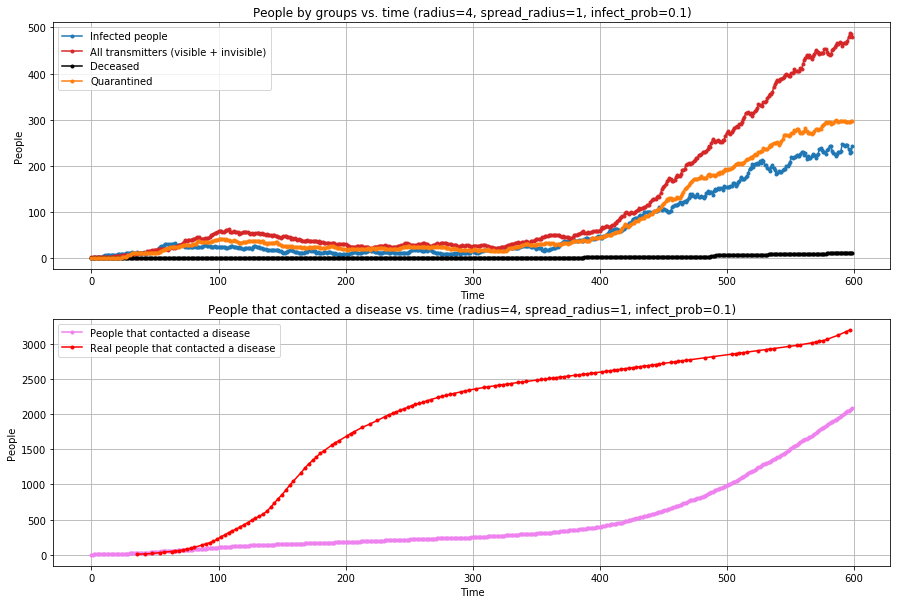

In [4]:
# Save detailed stats
df = pd.DataFrame(np.array([healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
                            transmitters_tracker, cured_tracker, dead_tracker, quarantine_tracker]).T,
                  columns=['healthy', 'infected', 'invisible_transmitters', 'transmitters', 'cured', 'dead', 'quarantined'])
if SAVE_DATA:
    df.to_csv(os.path.join(plot_disease_matrix, 'stats.csv'), sep='\t')

# Save progress plot
fig, ax = plt.subplots(nrows=2, figsize=(15, 2 * 5))

ax[0].plot(infected_tracker, '.-', c='tab:blue', label='Infected people')
ax[0].plot(invisible_transmitters_tracker + transmitters_tracker, '.-', c='tab:red', label='All transmitters (visible + invisible)')
ax[0].plot(dead_tracker, '.-', c='black', label='Deceased')
# ax[0].plot(cured_tracker, '.-', c='tab:green', label='Cured')
ax[0].plot(quarantine_tracker, '.-', c='tab:orange', label='Quarantined')
# ax[0].plot(invisible_transmitters_tracker + transmitters_tracker + cured_tracker, '.-', c='tab:cyan', label='All_people_were_infected')

ax[0].set_ylabel('People')
ax[0].set_xlabel('Time')
ax[0].set_title(f'People by groups vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[0].grid()
ax[0].legend()

ax[1].plot(infected_tracker + invisible_transmitters_tracker + transmitters_tracker + dead_tracker + cured_tracker, '.-',
           c='violet', label='People that contacted a disease')

ax[1].set_ylabel('People')
ax[1].set_xlabel('Time')
ax[1].set_title(f'People that contacted a disease vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[1].plot(real_epoch[:np.searchsorted(real_epoch, len(infected_tracker))], real_cases[:np.searchsorted(real_epoch, len(infected_tracker))], '.-', c='red', label='Real people that contacted a disease')
ax[1].grid()
ax[1].legend()

if SAVE_DATA:
    fig.savefig(os.path.join(plot_disease_matrix, 'stats_ts.png'), dpi=300);

plt.show()

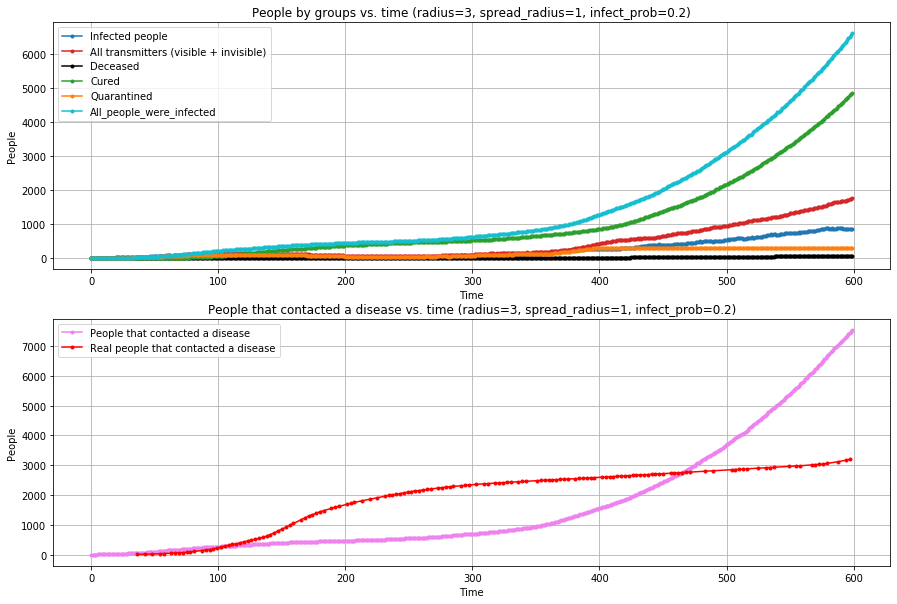

In [14]:
# Save detailed stats
df = pd.DataFrame(np.array([healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
                            transmitters_tracker, cured_tracker, dead_tracker, quarantine_tracker]).T,
                  columns=['healthy', 'infected', 'invisible_transmitters', 'transmitters', 'cured', 'dead', 'quarantined'])
if SAVE_DATA:
    df.to_csv(os.path.join(plot_disease_matrix, 'stats.csv'), sep='\t')

# Save progress plot
fig, ax = plt.subplots(nrows=2, figsize=(15, 2 * 5))

ax[0].plot(infected_tracker, '.-', c='tab:blue', label='Infected people')
ax[0].plot(invisible_transmitters_tracker + transmitters_tracker, '.-', c='tab:red', label='All transmitters (visible + invisible)')
ax[0].plot(dead_tracker, '.-', c='black', label='Deceased')
ax[0].plot(cured_tracker, '.-', c='tab:green', label='Cured')
ax[0].plot(quarantine_tracker, '.-', c='tab:orange', label='Quarantined')
ax[0].plot(invisible_transmitters_tracker + transmitters_tracker + cured_tracker, '.-', c='tab:cyan', label='All_people_were_infected')

ax[0].set_ylabel('People')
ax[0].set_xlabel('Time')
ax[0].set_title(f'People by groups vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[0].grid()
ax[0].legend()

ax[1].plot(infected_tracker + invisible_transmitters_tracker + transmitters_tracker + dead_tracker + cured_tracker, '.-',
           c='violet', label='People that contacted a disease')

ax[1].set_ylabel('People')
ax[1].set_xlabel('Time')
ax[1].set_title(f'People that contacted a disease vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[1].plot(real_epoch[:np.searchsorted(real_epoch, len(infected_tracker))], real_cases[:np.searchsorted(real_epoch, len(infected_tracker))], '.-', c='red', label='Real people that contacted a disease')
ax[1].grid()
ax[1].legend()

if SAVE_DATA:
    fig.savefig(os.path.join(plot_disease_matrix, 'stats_ts.png'), dpi=300);

plt.show()

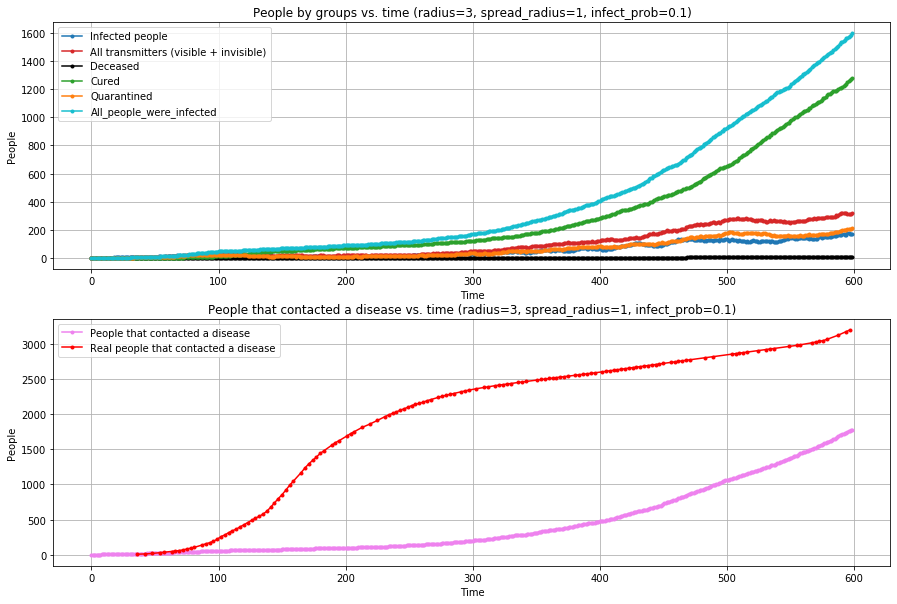

In [11]:
# Save detailed stats
df = pd.DataFrame(np.array([healthy_tracker, infected_tracker, invisible_transmitters_tracker, \
                            transmitters_tracker, cured_tracker, dead_tracker, quarantine_tracker]).T,
                  columns=['healthy', 'infected', 'invisible_transmitters', 'transmitters', 'cured', 'dead', 'quarantined'])
if SAVE_DATA:
    df.to_csv(os.path.join(plot_disease_matrix, 'stats.csv'), sep='\t')

# Save progress plot
fig, ax = plt.subplots(nrows=2, figsize=(15, 2 * 5))

ax[0].plot(infected_tracker, '.-', c='tab:blue', label='Infected people')
ax[0].plot(invisible_transmitters_tracker + transmitters_tracker, '.-', c='tab:red', label='All transmitters (visible + invisible)')
ax[0].plot(dead_tracker, '.-', c='black', label='Deceased')
ax[0].plot(cured_tracker, '.-', c='tab:green', label='Cured')
ax[0].plot(quarantine_tracker, '.-', c='tab:orange', label='Quarantined')
ax[0].plot(invisible_transmitters_tracker + transmitters_tracker + cured_tracker, '.-', c='tab:cyan', label='All_people_were_infected')

ax[0].set_ylabel('People')
ax[0].set_xlabel('Time')
ax[0].set_title(f'People by groups vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[0].grid()
ax[0].legend()

ax[1].plot(infected_tracker + invisible_transmitters_tracker + transmitters_tracker + dead_tracker + cured_tracker, '.-',
           c='violet', label='People that contacted a disease')

ax[1].set_ylabel('People')
ax[1].set_xlabel('Time')
ax[1].set_title(f'People that contacted a disease vs. time (radius={radius}, spread_radius={spread_radius}, infect_prob={infect_prob})')
ax[1].plot(real_epoch[:np.searchsorted(real_epoch, len(infected_tracker))], real_cases[:np.searchsorted(real_epoch, len(infected_tracker))], '.-', c='red', label='Real people that contacted a disease')
ax[1].grid()
ax[1].legend()

if SAVE_DATA:
    fig.savefig(os.path.join(plot_disease_matrix, 'stats_ts.png'), dpi=300);

plt.show()